# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

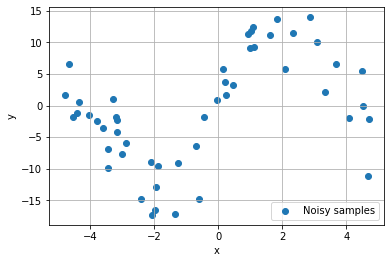

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

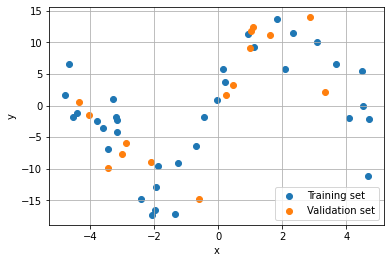

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

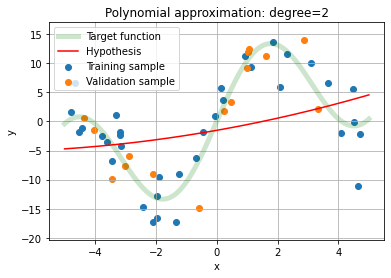

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

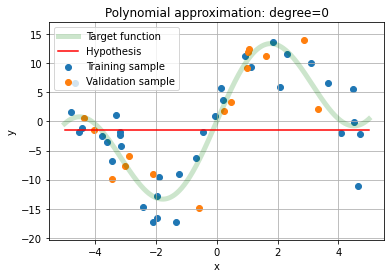

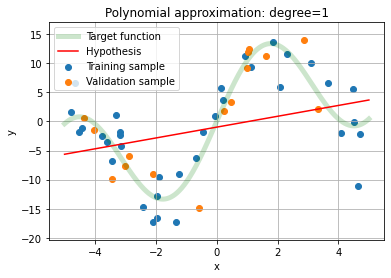

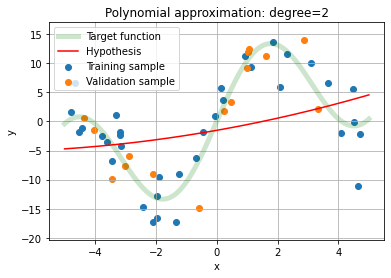

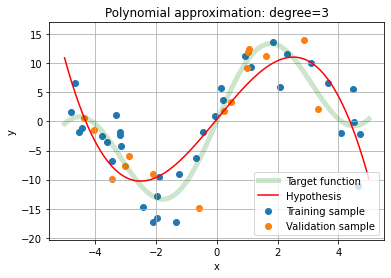

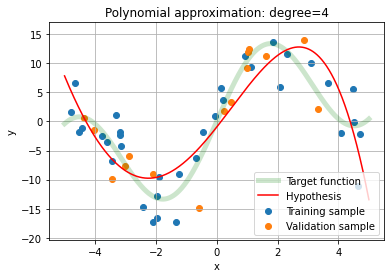

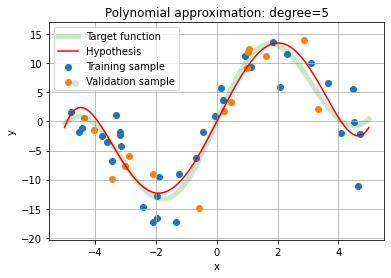

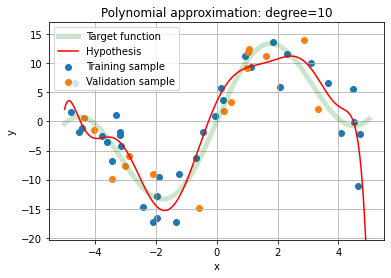

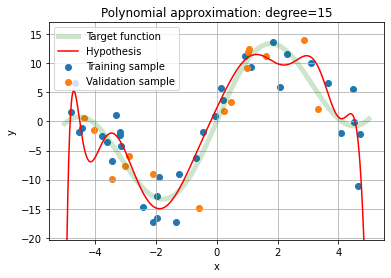

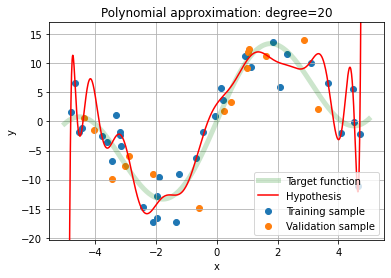

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

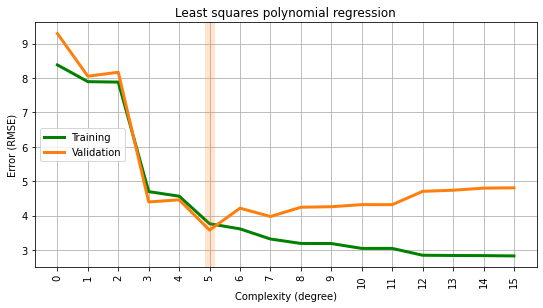

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, y_lim=None,
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph', x_axis_scale=None,
                       show_points=None):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, color='g', label='Training', lw=3)
    plt.plot(x, metric_valid, color='C1', label='Validation', lw=3)
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    if show_points:
        plt.plot(x, metric_train, label='Training', lw=3, marker='o', color='g')
        plt.plot(x, metric_valid, color='C1', label=f'Validation: {np.min(metric_valid):.2f}', lw=3, marker='o')
    if y_lim:
        plt.ylim([0, y_lim])
    if x_axis_scale:
        plt.xscale('log')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

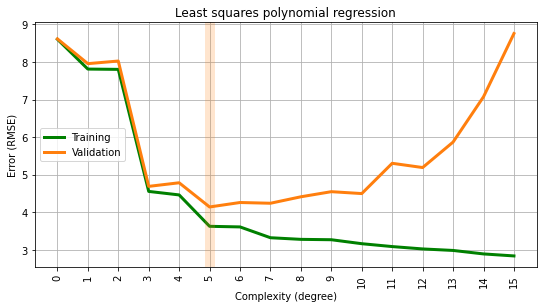

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

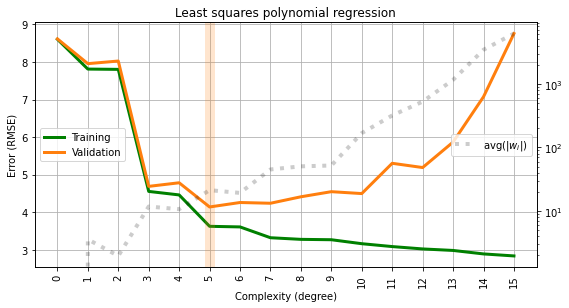

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

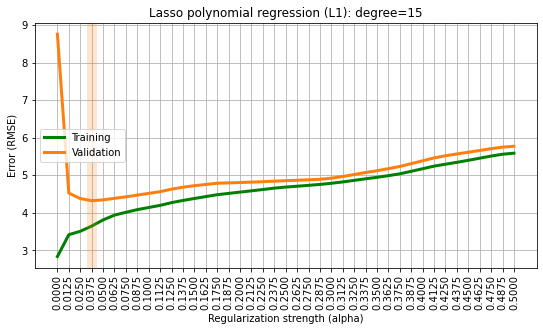

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

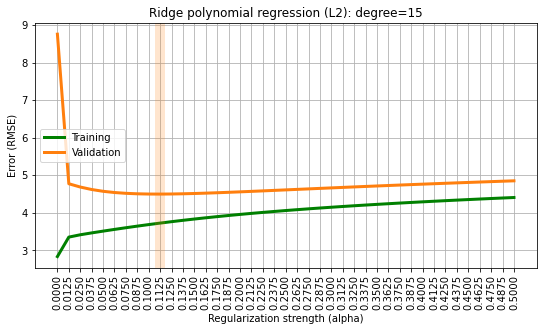

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
%%time
params_grid = {
    'pol__degree': DEGREES[1:10]
}
grid = GridSearchCV(make_model(degree=1), param_grid=params_grid, cv=5,\
                    scoring='neg_root_mean_squared_error', n_jobs=-1, return_train_score=True)
grid.fit(X_diabetes, y_diabetes)

rmse_train, rmse_valid = -grid.cv_results_['mean_train_score'], -grid.cv_results_['mean_test_score']

/Users/kremenevskiy/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 157 ms, sys: 156 ms, total: 312 ms
Wall time: 23.7 s


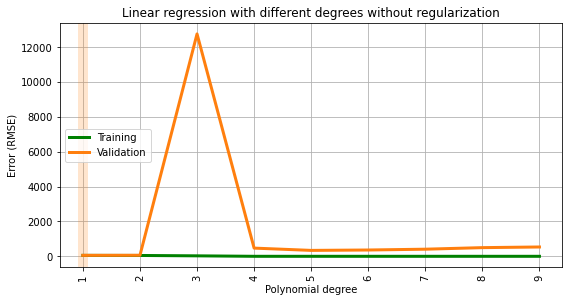

In [23]:
plot_fitting_graph(DEGREES[1:10], rmse_train, rmse_valid, 
                   xlabel='Polynomial degree', ylabel='Error (RMSE)', 
                   title='Linear regression with different degrees without regularization')

> Lets little bit scale

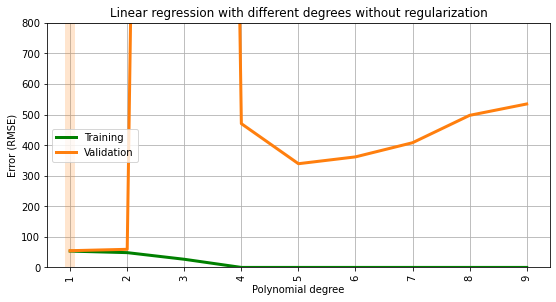

In [24]:
plot_fitting_graph(DEGREES[1:10], rmse_train, rmse_valid, 
                   xlabel='Polynomial degree', ylabel='Error (RMSE)', 
                   title='Linear regression with different degrees without regularization',
                   y_lim=800)

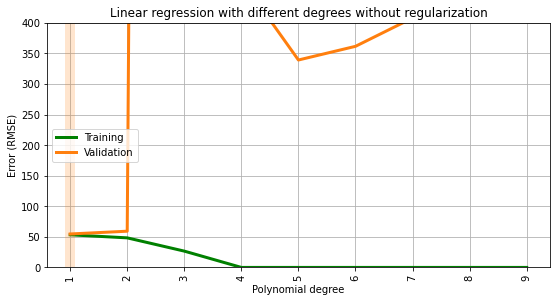

In [25]:
plot_fitting_graph(DEGREES[1:10], rmse_train, rmse_valid, 
                   xlabel='Polynomial degree', ylabel='Error (RMSE)', 
                   title='Linear regression with different degrees without regularization',
                   y_lim=400)

> wee see that overfitting starts with degree of 2,
    becouse validation error is more then before on first degree
> but the most overfit is on degree 3
> on degree of 4 wee see that out error is already 0, thats mean we fully predicting our train test
    and seems it will be hard to generalize

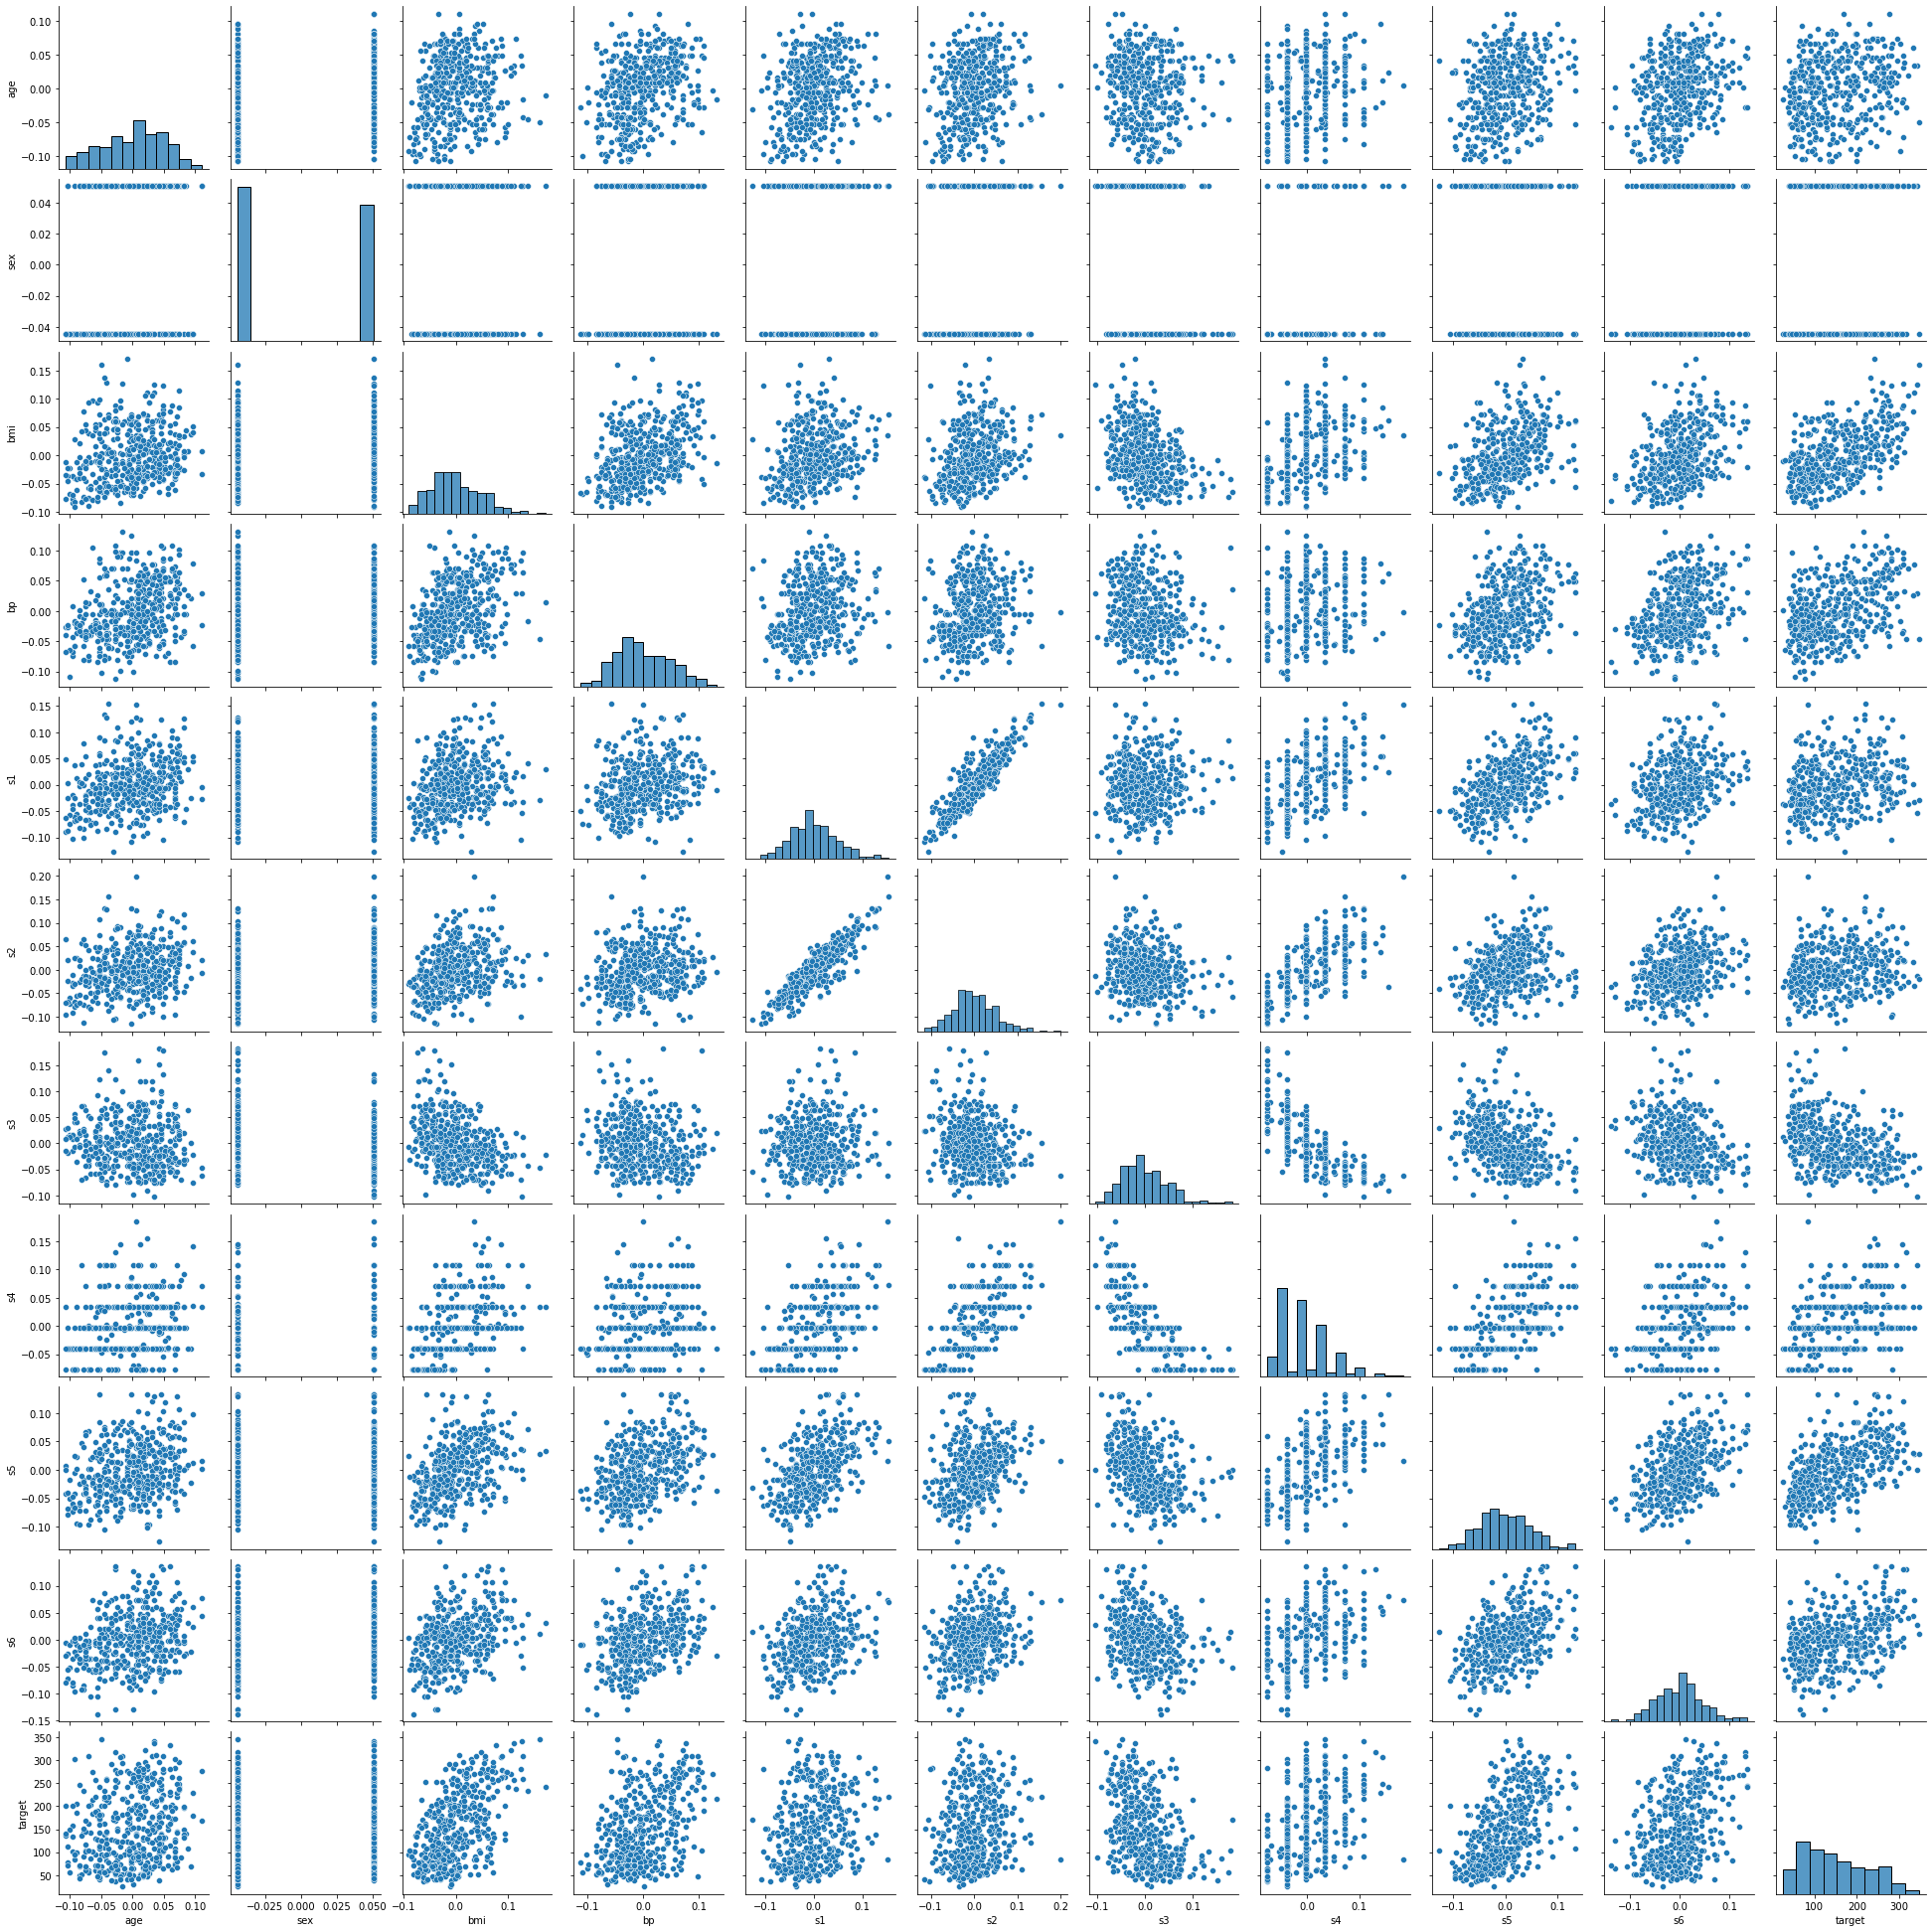

In [26]:
import seaborn as sns
# lets see relationship maybe we can see some non - linear patters
sns.pairplot(pd.concat([X_diabetes, y_diabetes], axis=1))

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [27]:
# generate poly features from first 8 becouse so computationally expensive make more
def make_poly_train(X, n_cols_poly=8, degree=15):
    poly = PolynomialFeatures(degree=15)
    X_poly = poly.fit_transform(X.iloc[:, :n_cols_poly])
    X_train = np.concatenate([X_poly, X.iloc[:, n_cols_poly:]], axis=1)
    return X_train

In [28]:
def get_model(penalty=None, alpha=0):
    model = None
    if alpha == 0:
        model = LinearRegression()
    elif penalty == 'L1':
        model = Lasso(alpha=alpha, random_state=SEED, max_iter=10000)
    elif penalty == 'L2':
        model = Ridge(alpha=alpha, random_state=SEED)
    sca = StandardScaler()
    return Pipeline([
        ('scaler', StandardScaler()),
        ('reg', model)
    ])

In [29]:
from tqdm.notebook import tqdm
def discover_penalty(X, y, penalty=None):
    rmse_train, rmse_test, avg_coef = [], [], []
    for alpha in tqdm(ALPHAS):
        results = cross_validate(get_model(penalty=penalty, alpha=alpha), X, y,
                                scoring='neg_root_mean_squared_error', cv=5,
                                return_train_score=True, return_estimator=True, n_jobs=-1)
        rmse_train.append(-np.mean(results['train_score']))
        rmse_test.append(-np.mean(results['test_score']))
        avg_coef.append(        
            np.mean([
                np.mean(np.abs(model['reg'].coef_))
                    for model in results['estimator']
            ]))
    return rmse_train, rmse_test, avg_coef

In [30]:
# get Poly features
X_train = make_poly_train(X_diabetes, n_cols_poly=3, degree=15)
X_train.shape

(442, 823)

#### L1

In [31]:
rmse_train, rmse_valid, avg_coef = discover_penalty(X_train, y_diabetes, penalty='L1')

  0%|          | 0/41 [00:00<?, ?it/s]

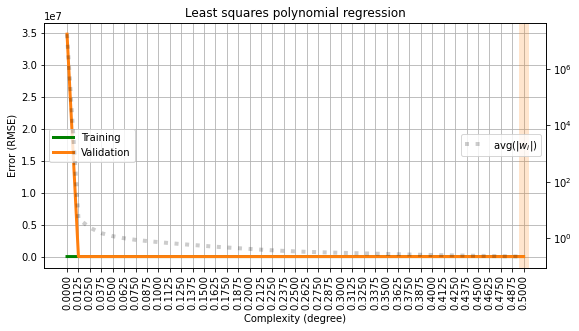

In [32]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

> lets make it bigger in [0, 150]

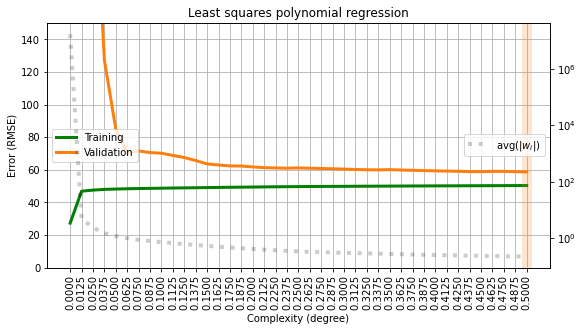

In [33]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression', y_lim=150)

#### L2

In [34]:
rmse_train, rmse_valid, avg_coef = discover_penalty(X_train, y_diabetes, penalty='L2')

  0%|          | 0/41 [00:00<?, ?it/s]

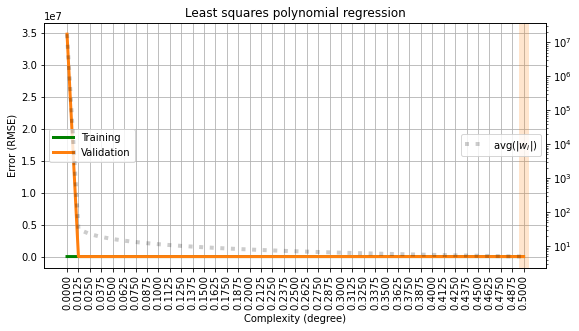

In [35]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

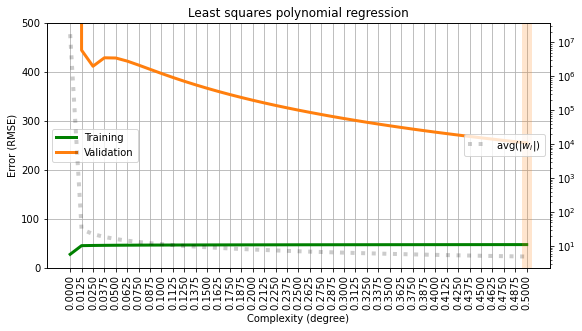

In [36]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression', y_lim=500)

#### Summary

> wee see that when make l1 or l2 regularization we decreasing our weights and thets leads to better generalization (less validation error) even if we have very big overfitting at the biggening with high order polunomial.
Also we will make regularization stonger maybe we can achive better results

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [37]:
## your observations/conclusions


In [38]:
# lets make smaller number of features to visualize it better
X_train = make_poly_train(X_diabetes, n_cols_poly=1, degree=15)
print('shape: ', X_train.shape)
x_train, x_test, y_train, y_test = train_test_split(X_train, y_diabetes, test_size=.3, shuffle=True)

shape:  (442, 25)


In [39]:
def show_regularization(X, y, penalty='L1'):
    w_labels = ['w%d' % i for i in range(1, X.shape[1]+1)]
    df_coefs = pd.DataFrame(index=w_labels)
    for alpha in ALPHAS:
        model = get_model(penalty=penalty, alpha=alpha)
        model.fit(X, y)
        coefs = model['reg'].coef_.reshape(-1,)
        df_coefs[f'alpha_{alpha:.2f}'] = coefs
        
        # count weights == 0
        zero_w_cnt = (coefs==0).sum()
        
        plt.figure(figsize=(8,8))
        sns.barplot(x=w_labels, y=coefs, label=f'num of zero weights: {zero_w_cnt}')

        plt.title(f'Wieghts of L1 regularization with alpha: {alpha:.3f}')
        plt.xticks(rotation='vertical')
        plt.xlabel('different weights')
        plt.ylabel('weights scale')
        plt.legend()
        plt.show()
    return df_coefs

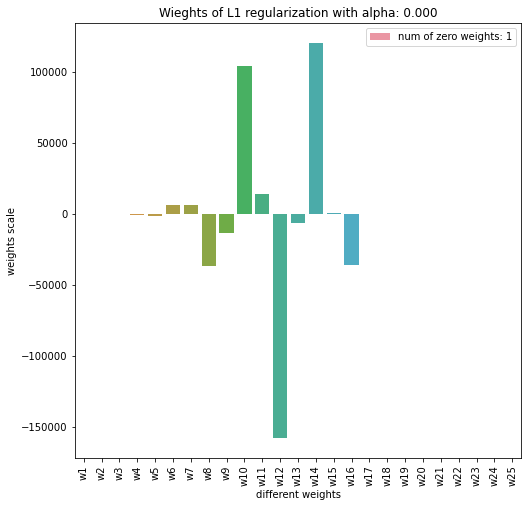

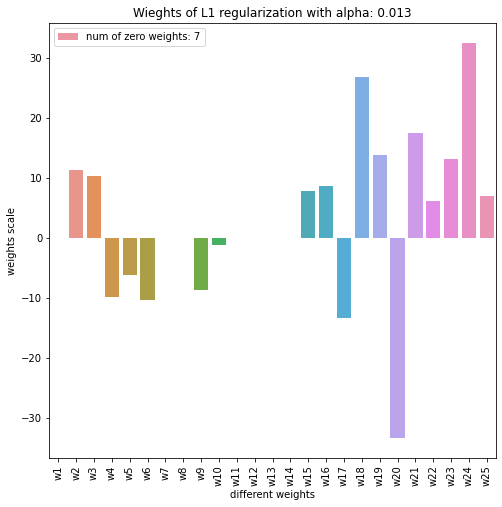

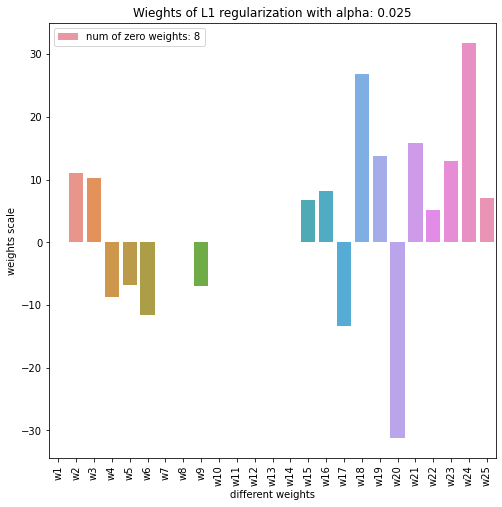

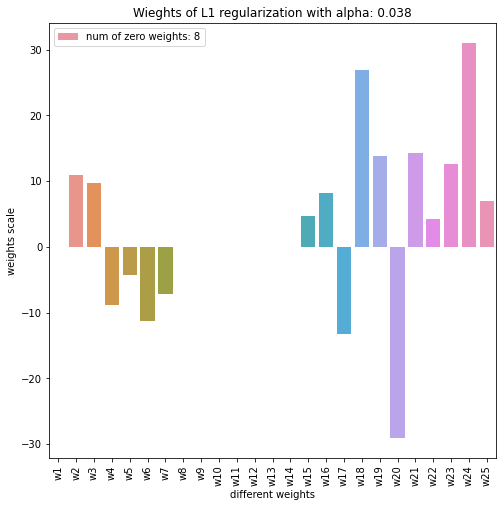

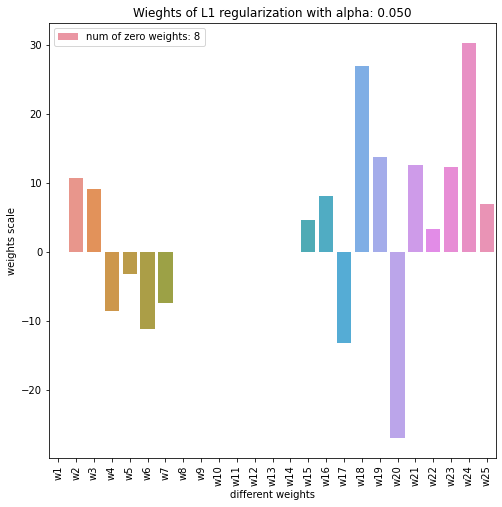

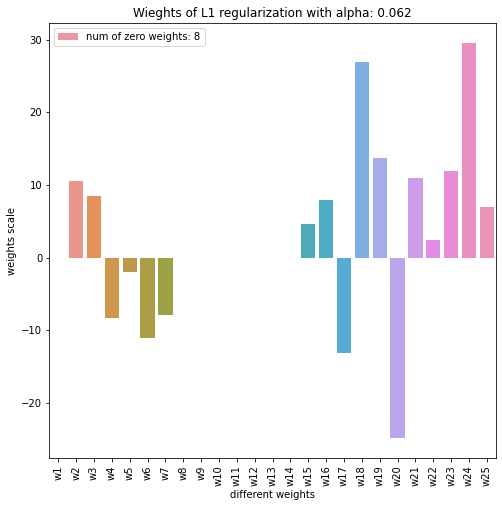

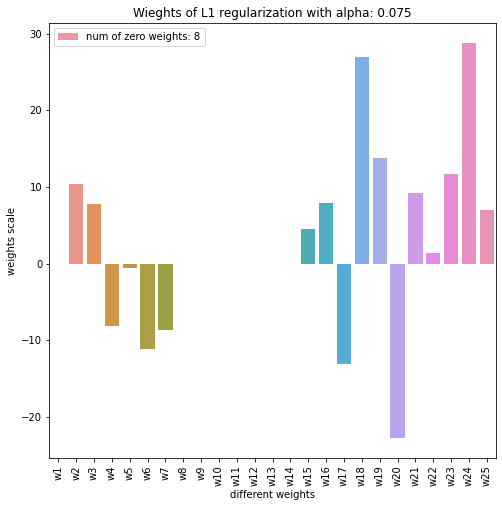

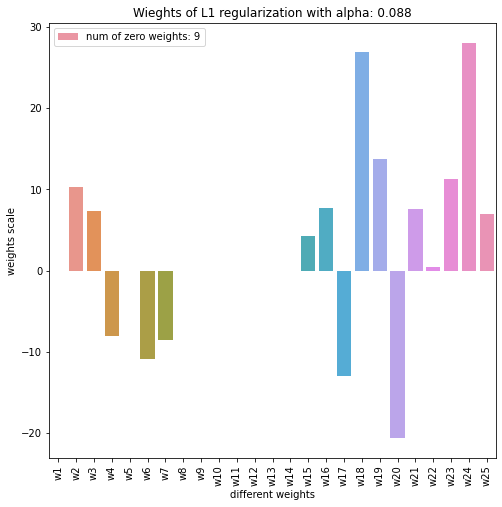

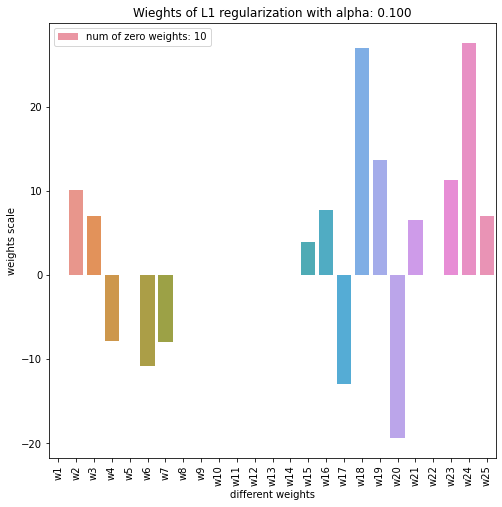

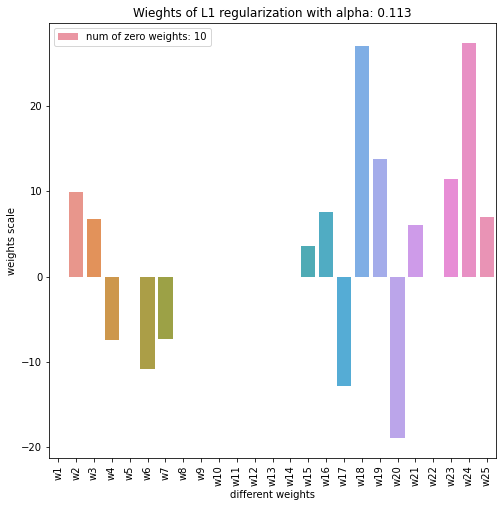

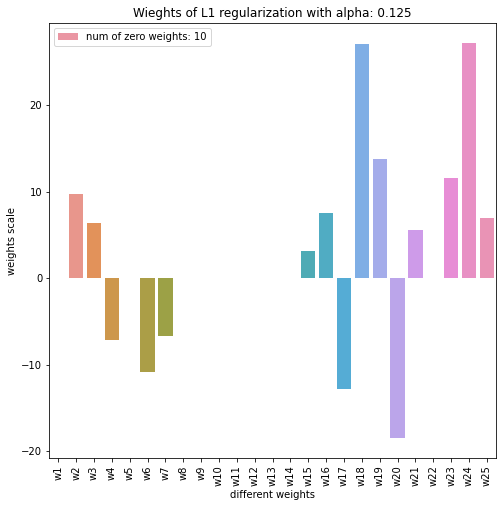

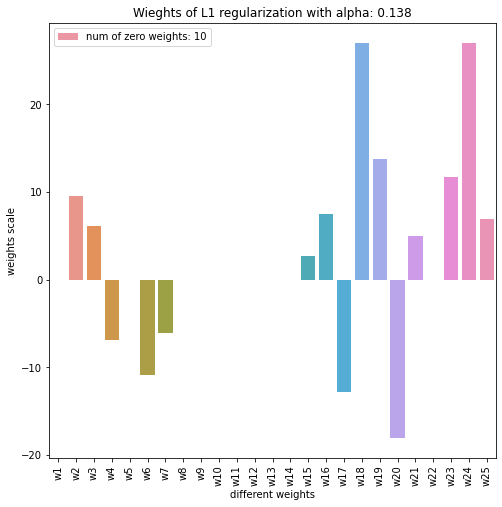

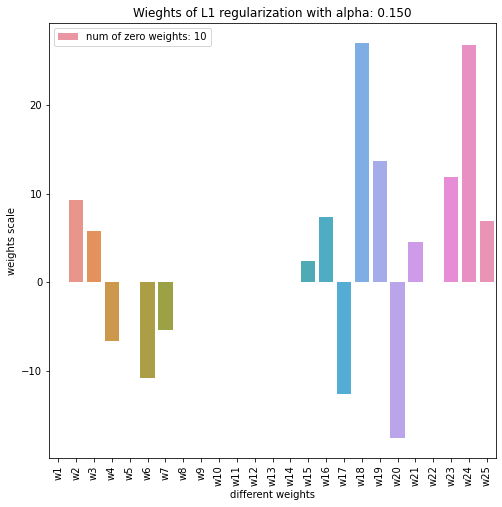

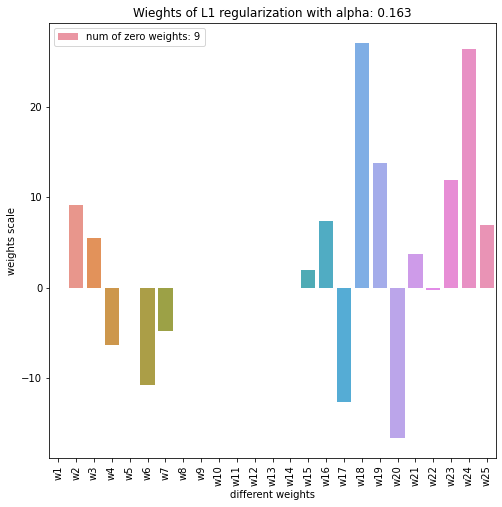

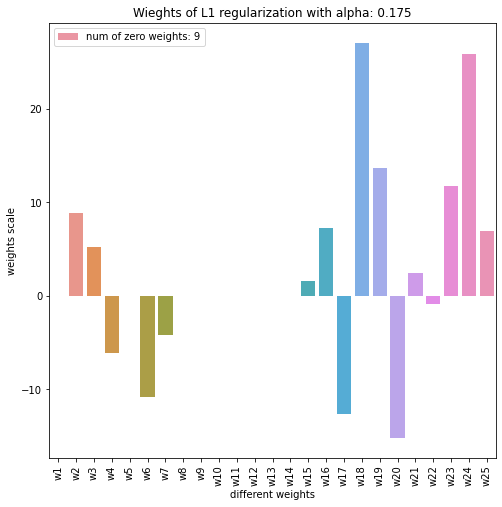

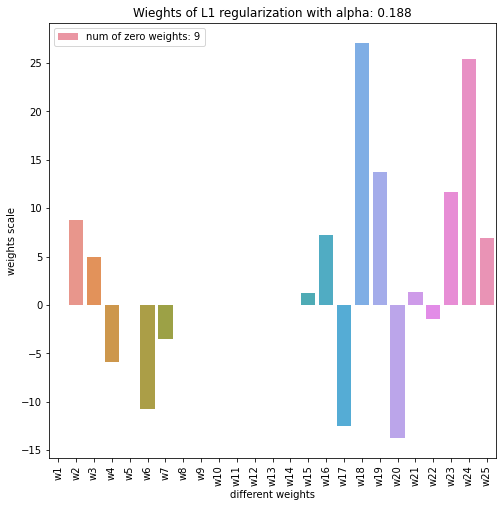

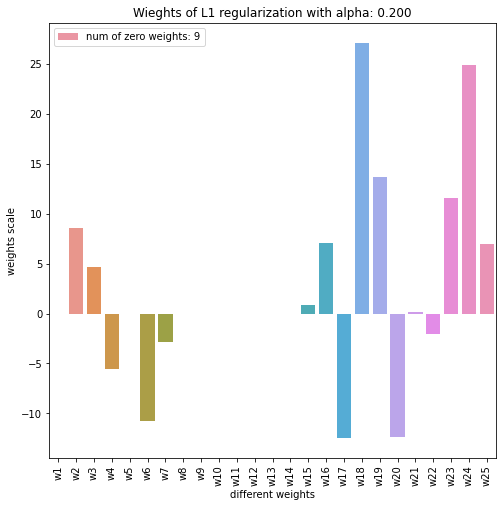

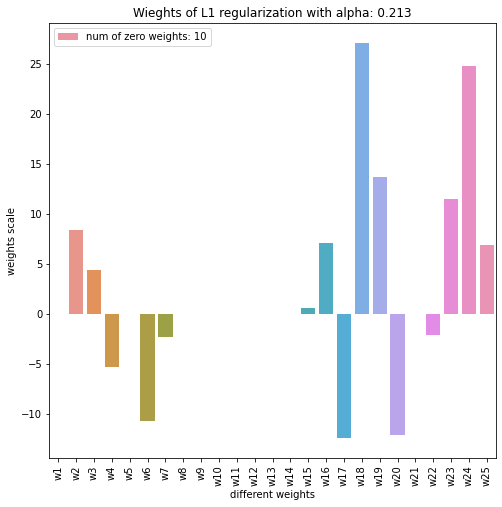

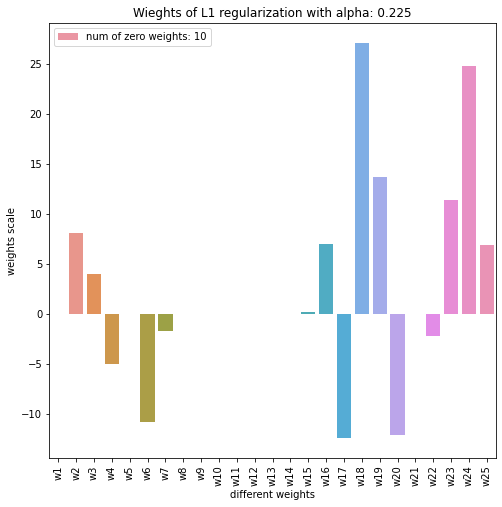

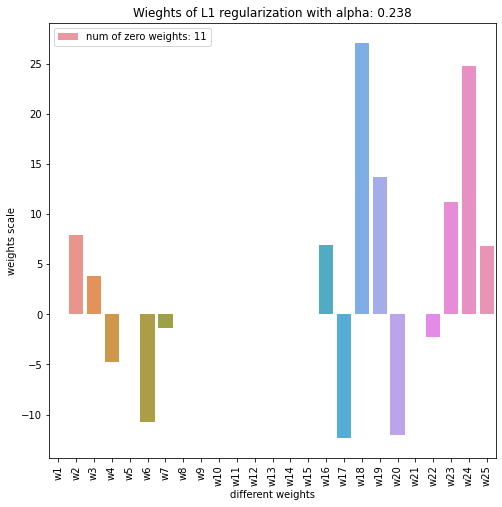

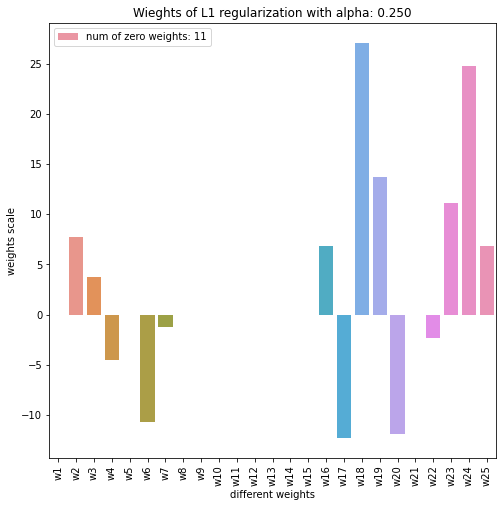

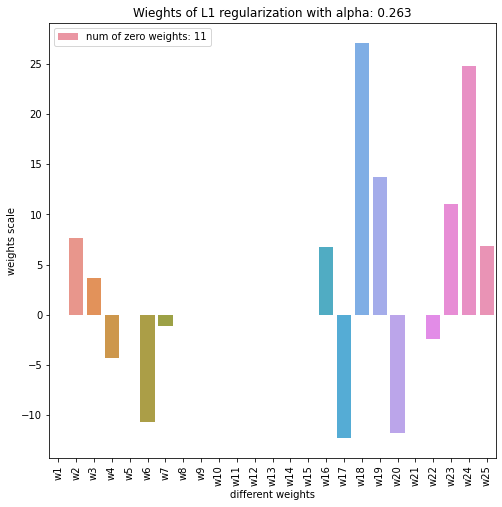

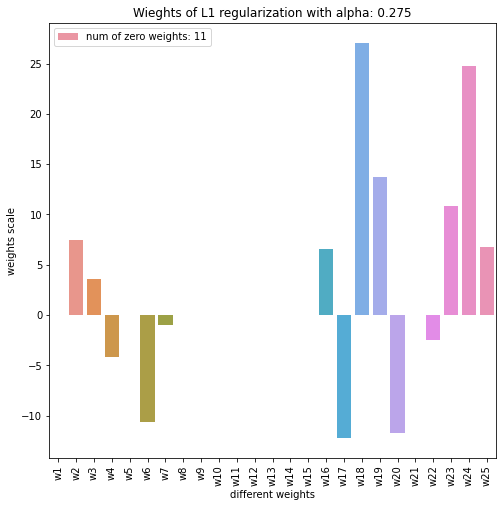

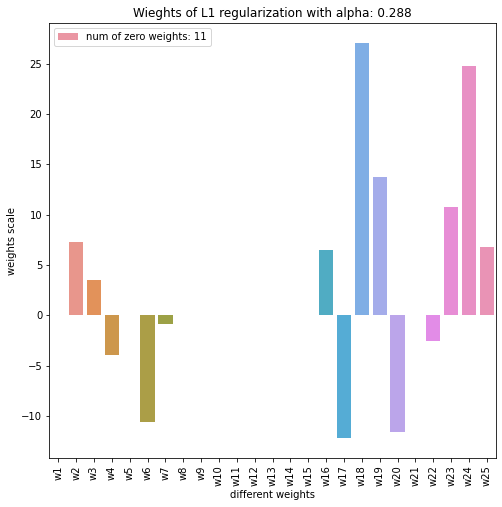

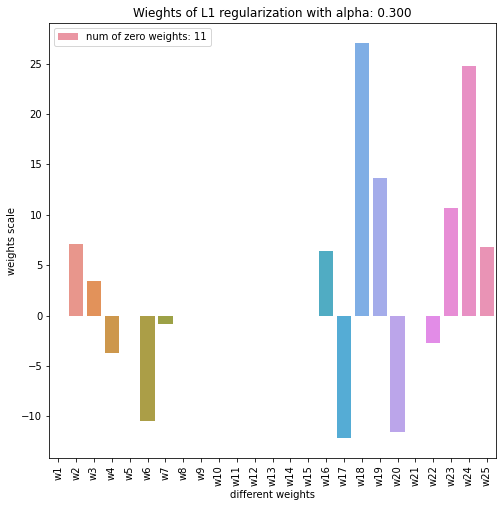

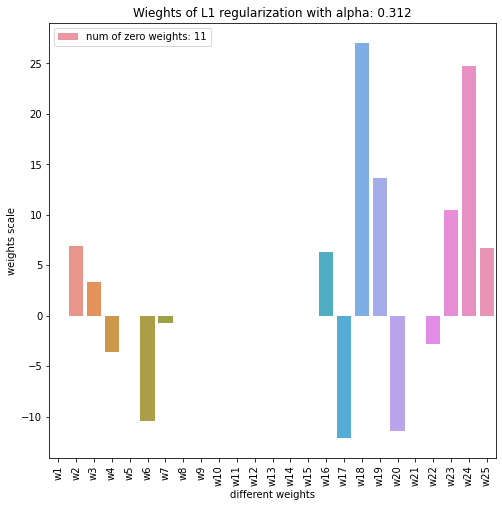

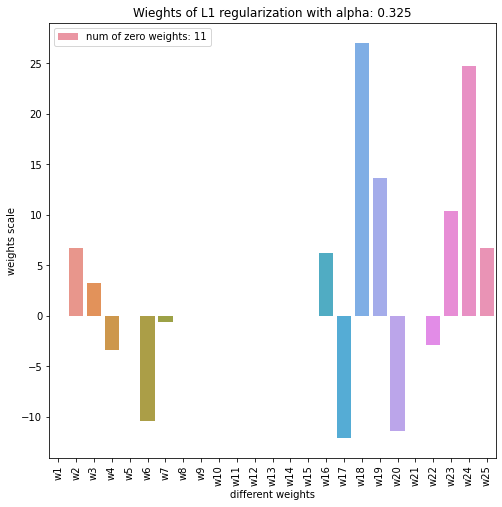

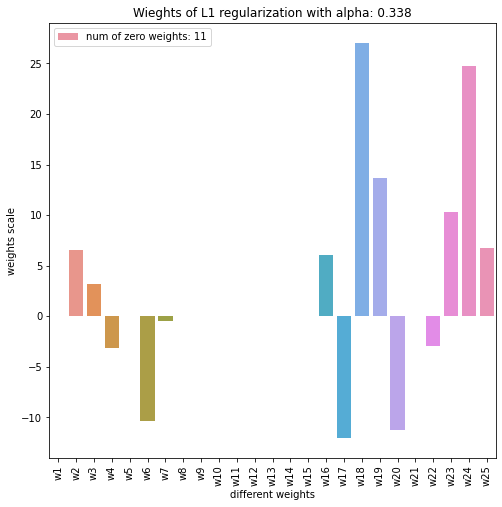

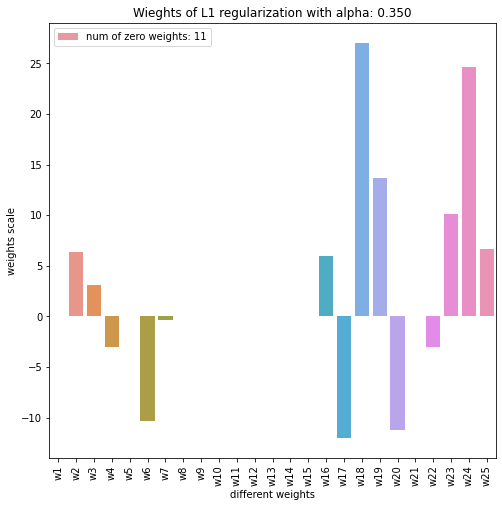

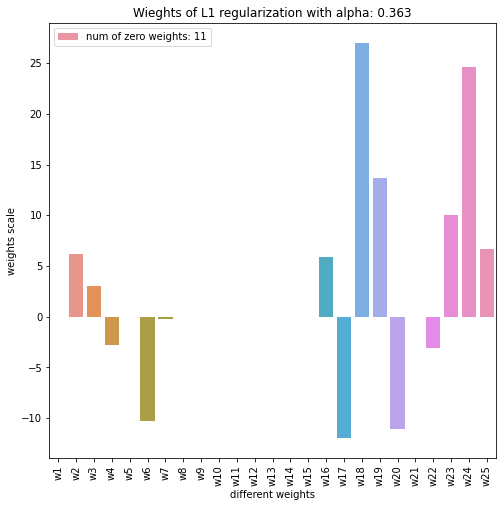

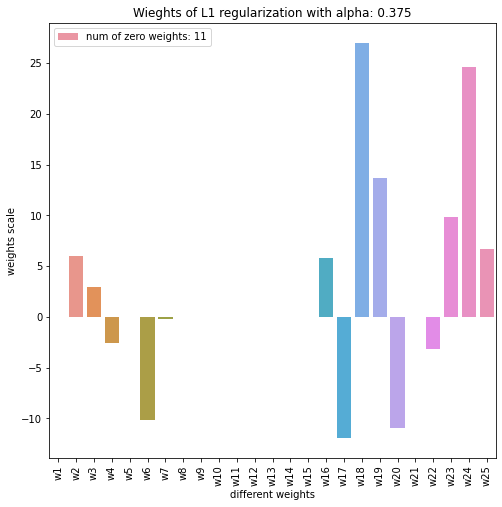

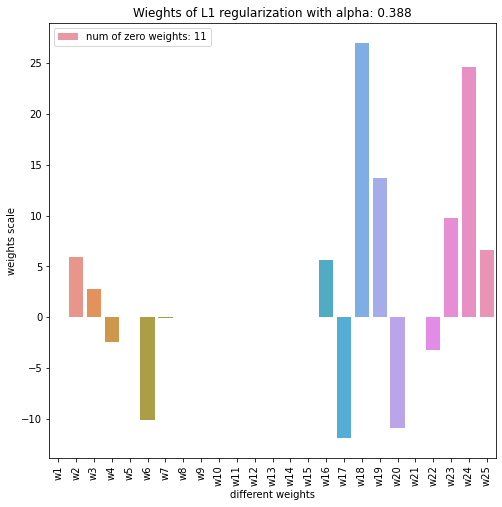

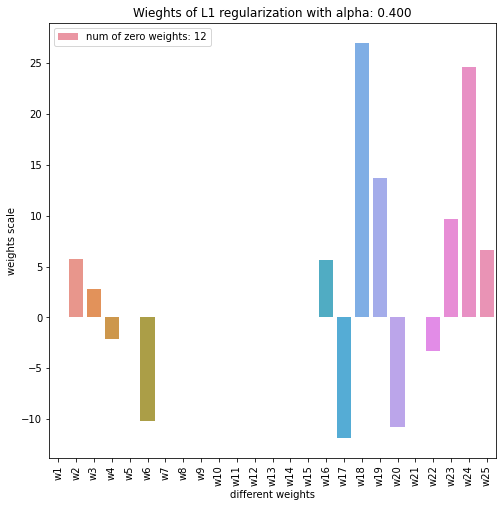

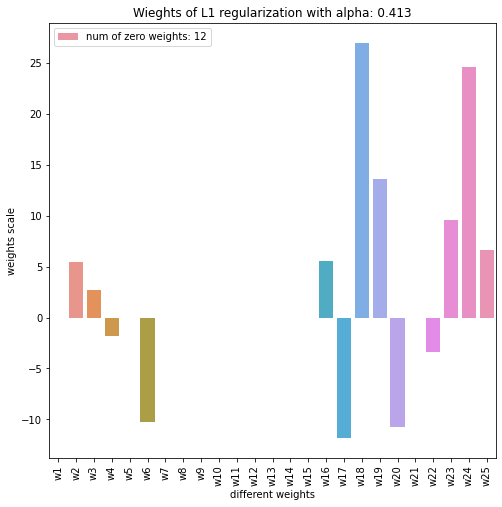

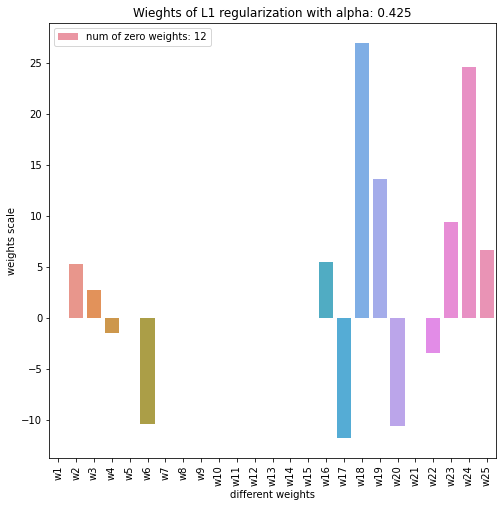

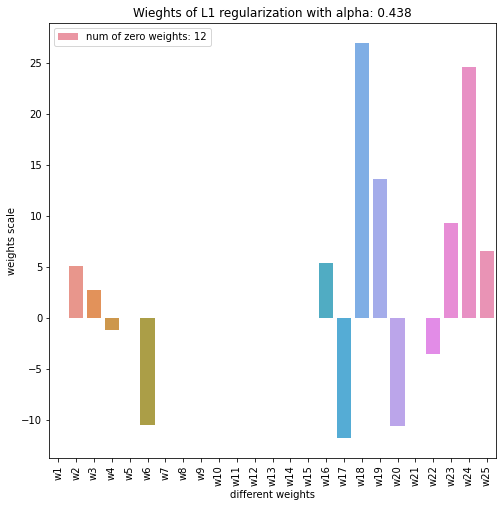

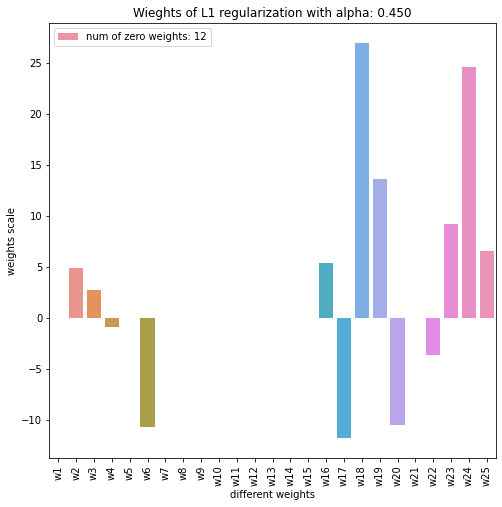

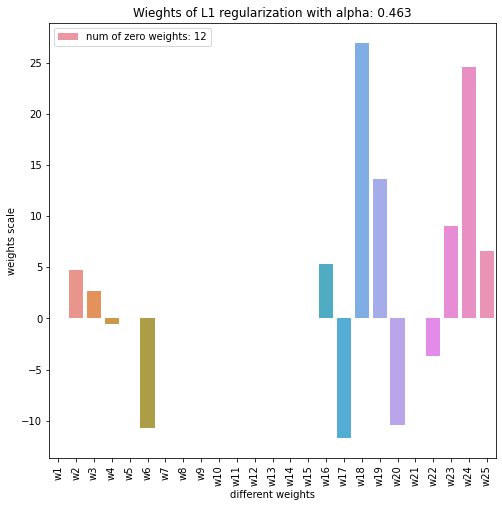

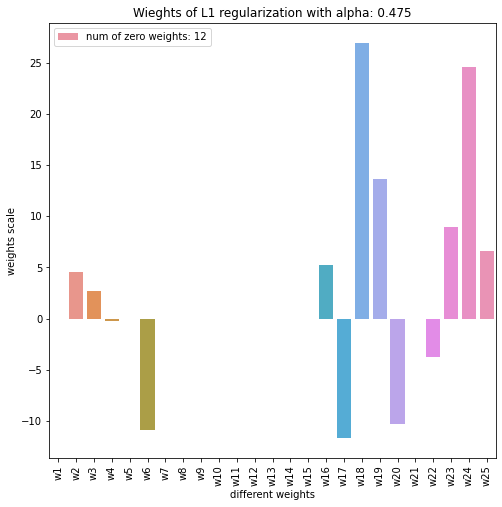

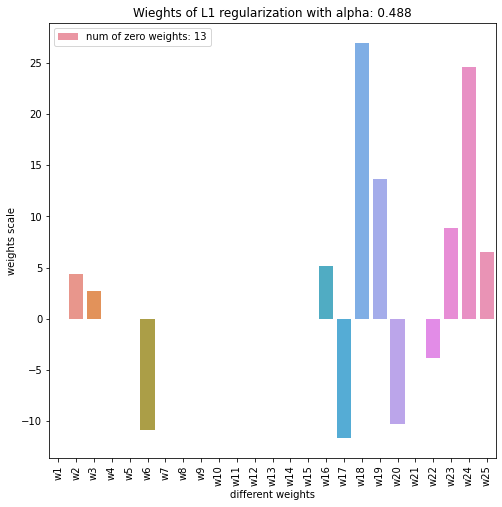

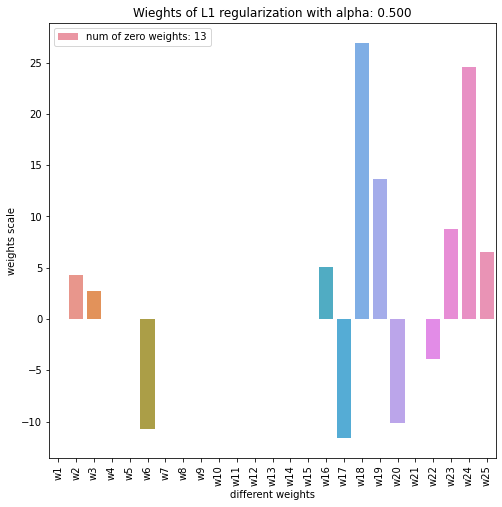

In [40]:
coefs_L1 = show_regularization(x_train, y_train, penalty='L1')

In [41]:
coefs_L1

,alpha_0.00,alpha_0.01,alpha_0.03,alpha_0.04,alpha_0.05,alpha_0.06,alpha_0.08,alpha_0.09,alpha_0.10,alpha_0.11,...,alpha_0.39,alpha_0.40,alpha_0.41,alpha_0.43,alpha_0.44,alpha_0.45,alpha_0.46,alpha_0.48,alpha_0.49,alpha_0.50
w1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
w2,23.153700,11.338096,11.012580,10.919978,10.752698,10.575757,10.390770,10.247873,10.079365,9.885271,...,5.878664,5.693664,5.496718,5.300522,5.103467,4.907173,4.710837,4.514463,4.345234,4.244137
w3,151.574677,10.301469,10.278791,9.759334,9.160910,8.493690,7.769815,7.289543,6.995060,6.701849,...,2.816609,2.765445,2.754240,2.743115,2.731897,2.720762,2.709622,2.698477,2.690242,2.689347
w4,-539.753840,-9.765784,-8.741916,-8.810884,-8.613436,-8.380828,-8.118951,-8.008409,-7.789471,-7.499403,...,-2.418567,-2.160464,-1.837273,-1.516569,-1.193015,-0.871987,-0.550823,-0.229529,-0.000000,-0.000000
w5,-1502.040875,-6.177217,-6.845002,-4.210516,-3.220851,-2.003764,-0.599423,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w6,6563.474061,-10.359668,-11.603342,-11.257960,-11.171526,-11.120191,-11.098056,-10.927134,-10.866469,-10.862263,...,-10.155494,-10.187772,-10.301631,-10.413202,-10.527394,-10.639263,-10.751257,-10.863371,-10.891043,-10.707563
w7,6445.016109,-0.000000,-0.000000,-7.147528,-7.443157,-7.946409,-8.620624,-8.560112,-7.946622,-7.305234,...,-0.055522,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w8,-36508.568350,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w9,-13478.952897,-8.696460,-6.966669,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w10,104091.276110,-1.124939,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Comment
> we see that with l1 regularization we have so much weights going to zero 
especially with alpha = 0.5, 12 of them are zeros.
Also total scale is decreasing

#### L2

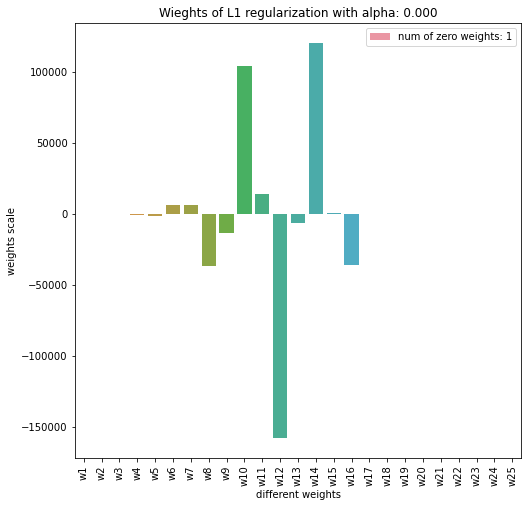

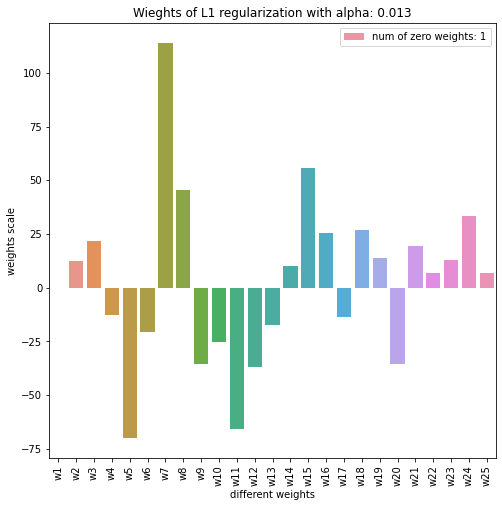

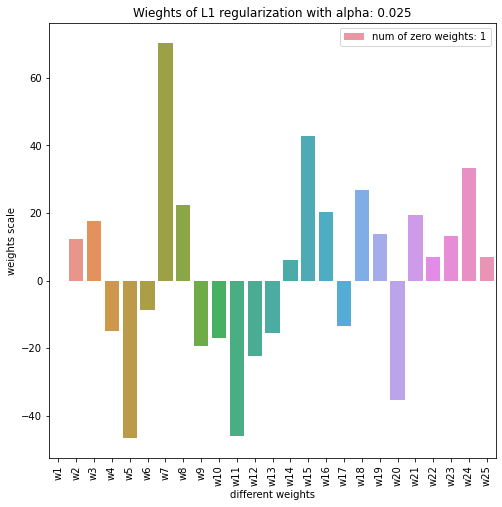

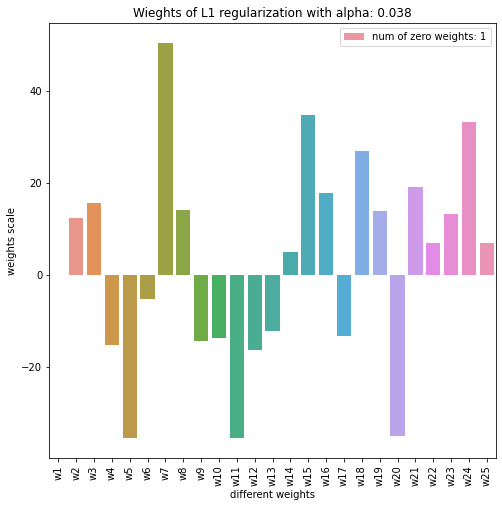

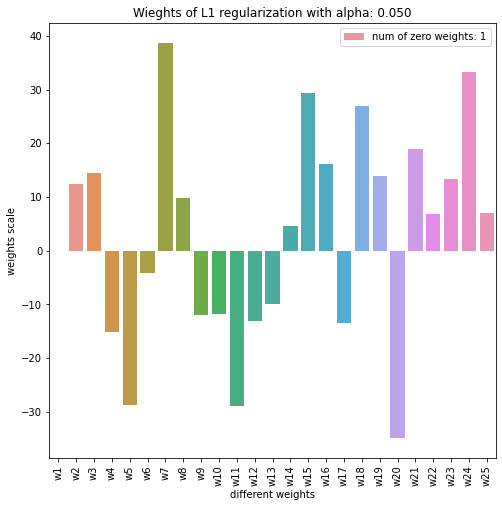

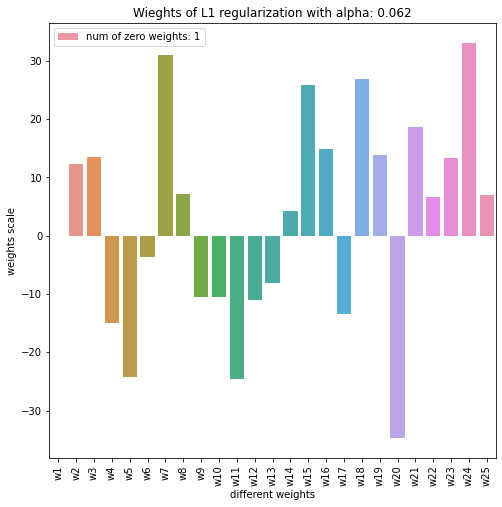

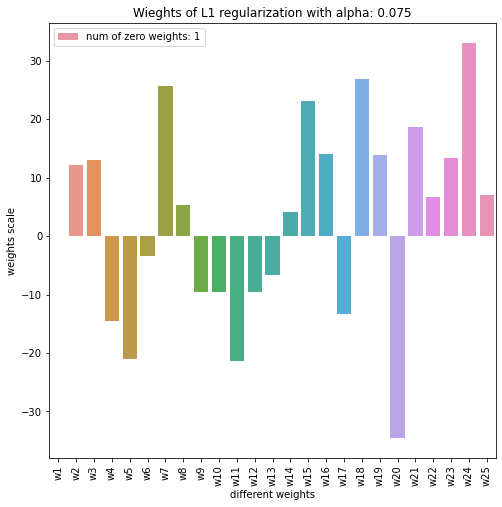

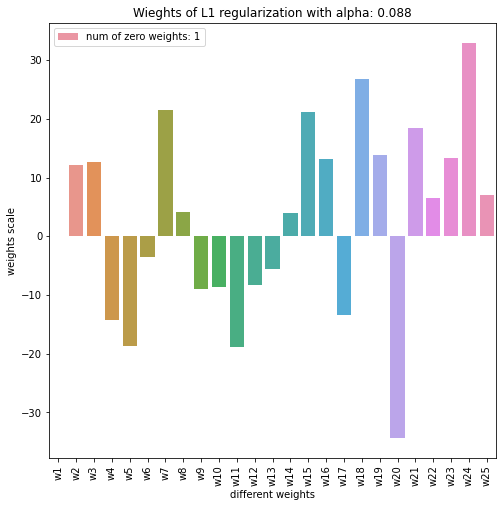

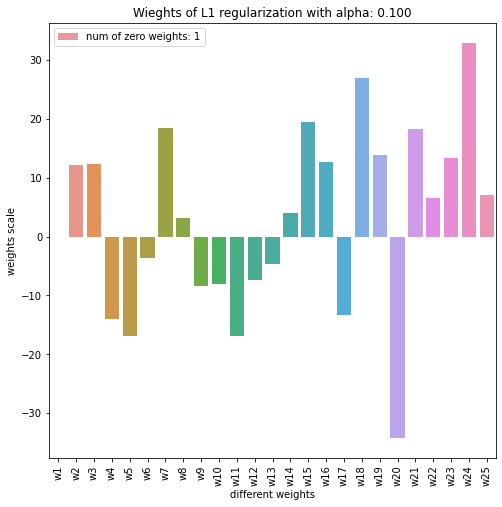

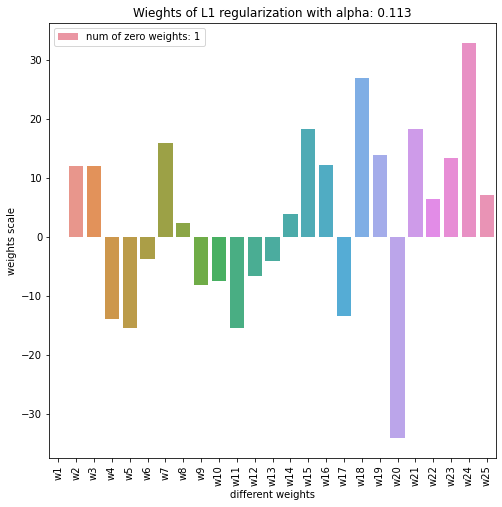

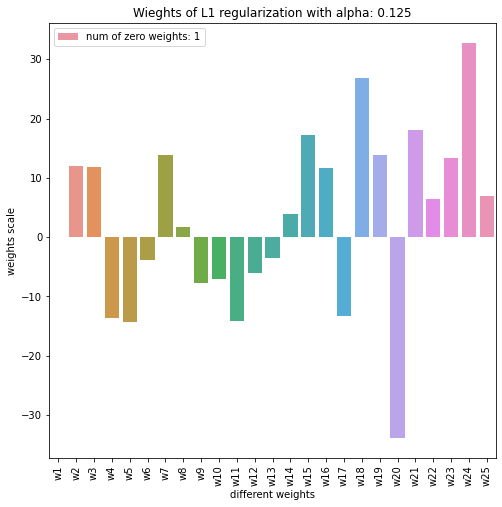

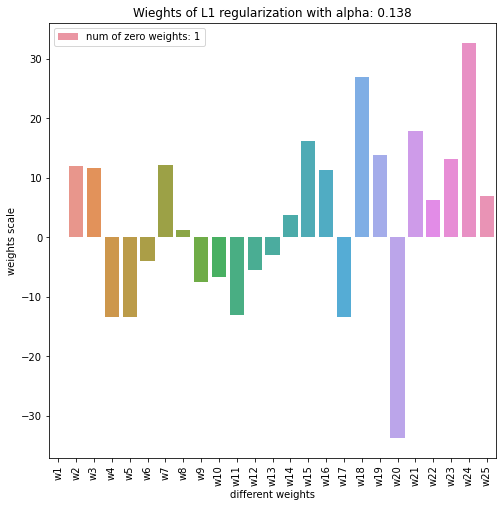

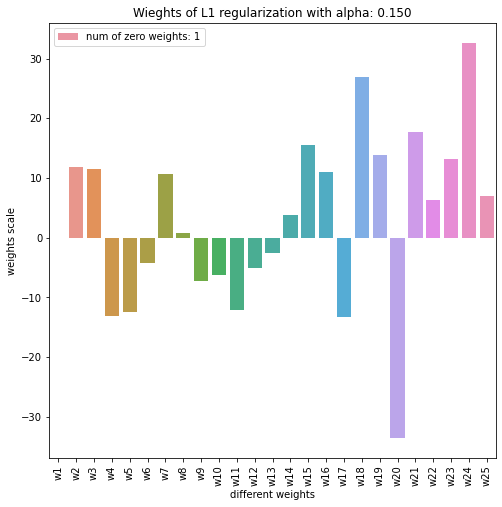

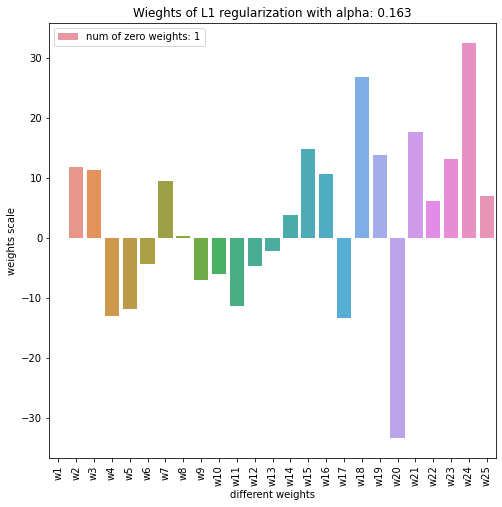

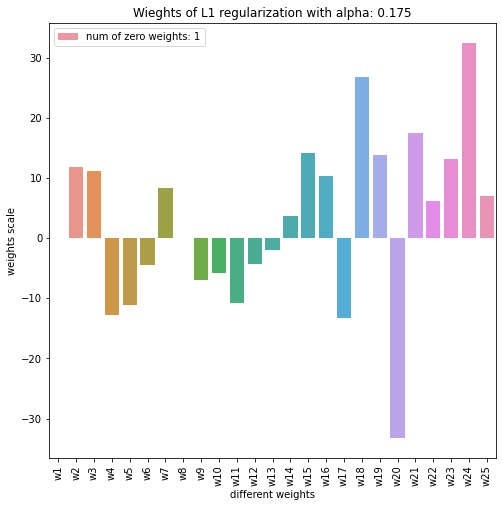

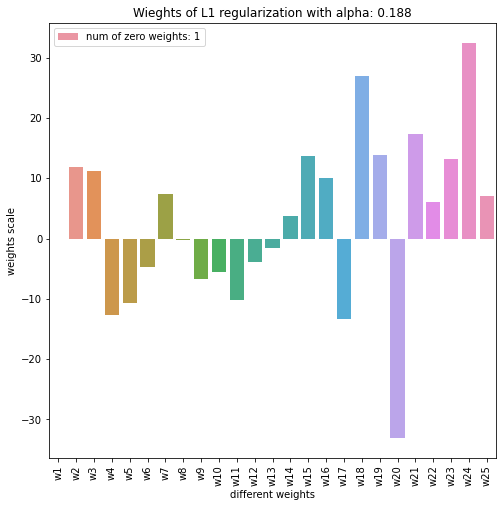

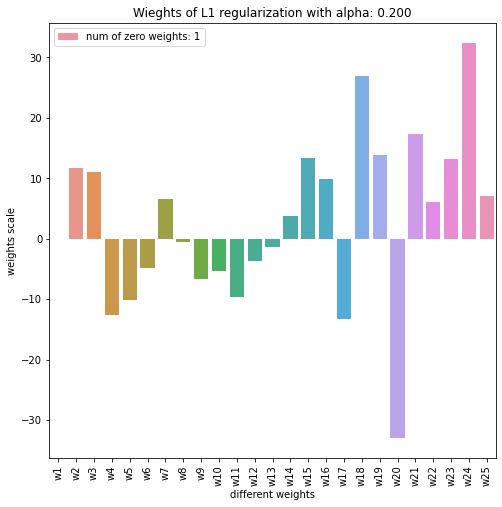

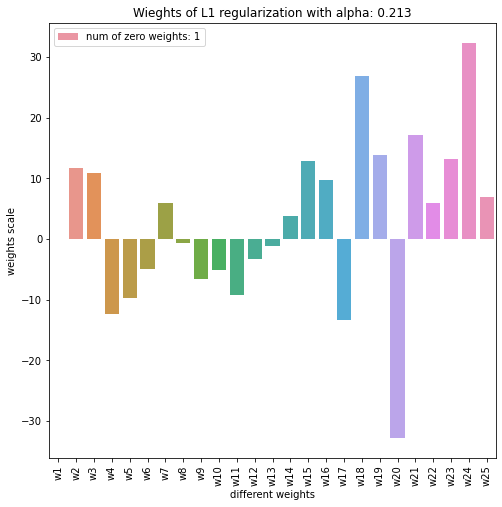

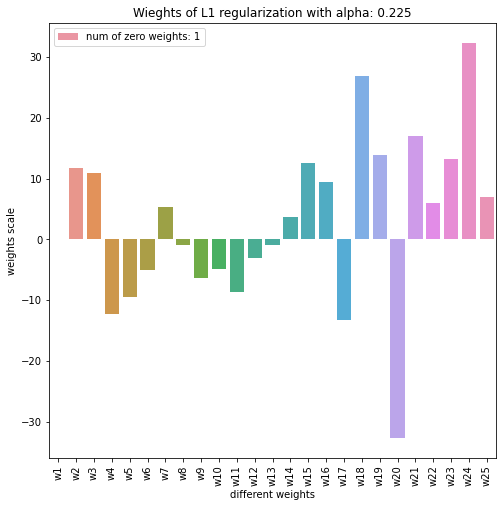

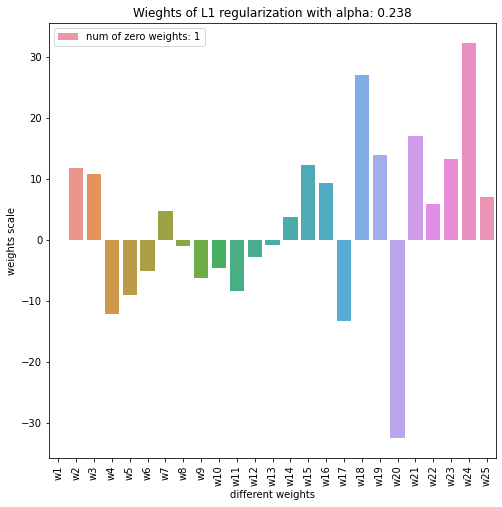

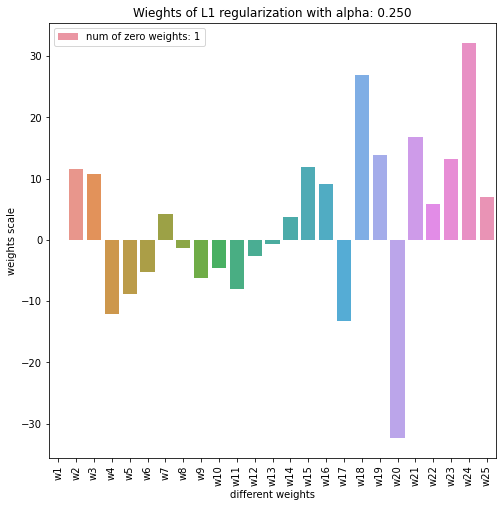

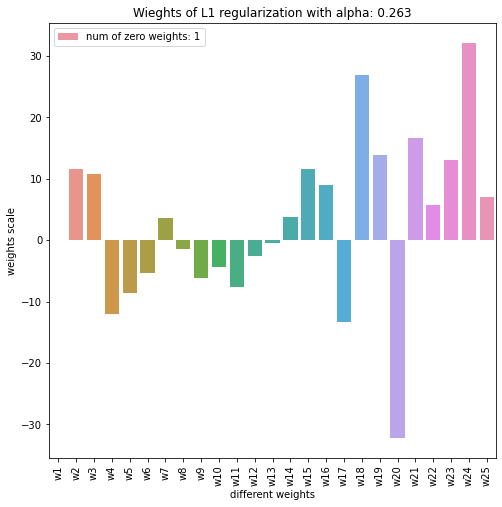

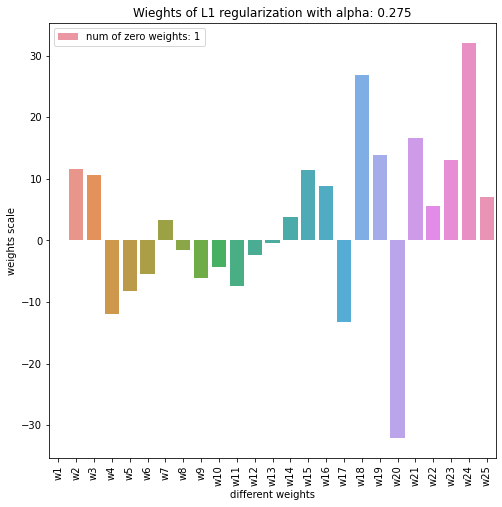

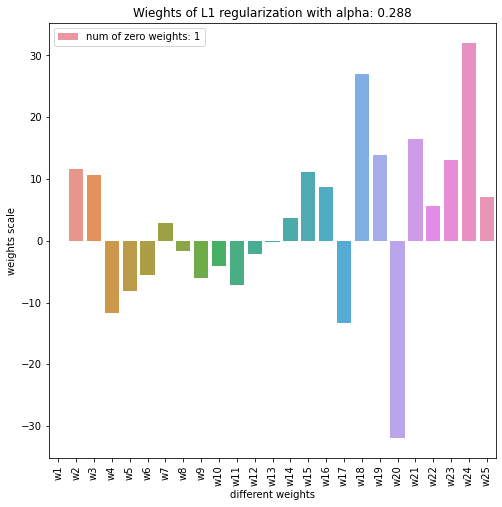

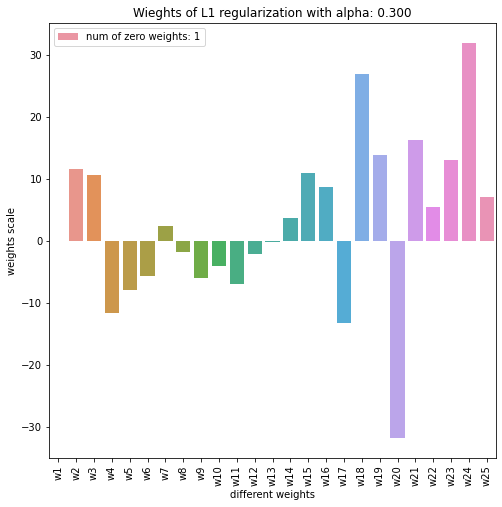

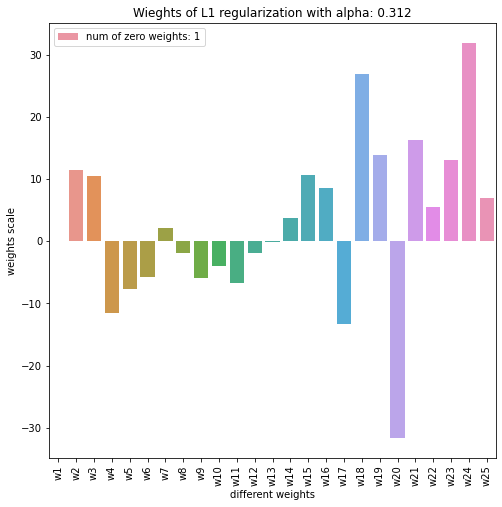

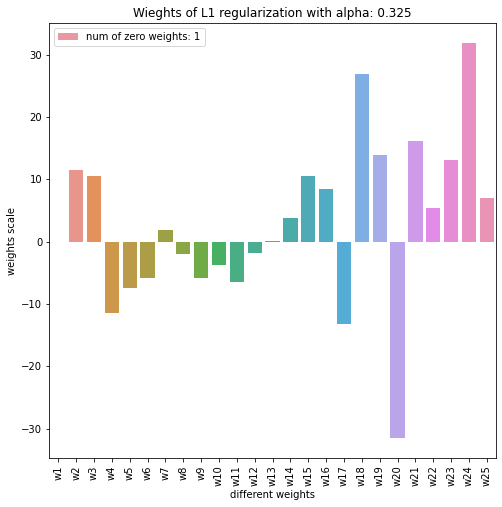

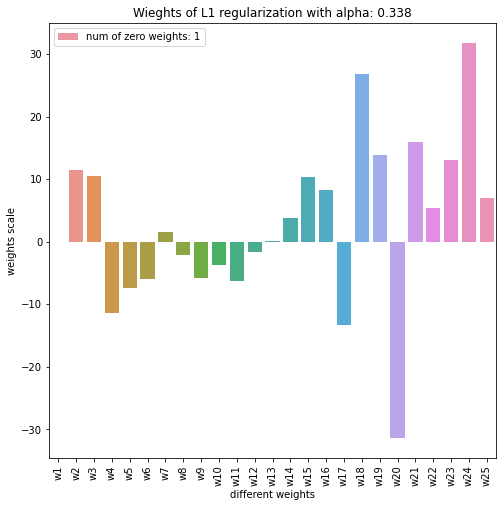

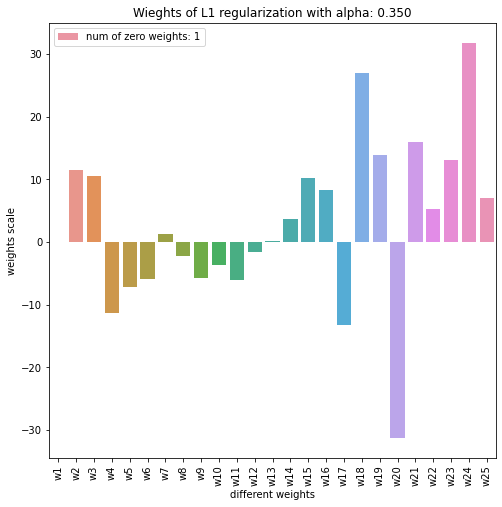

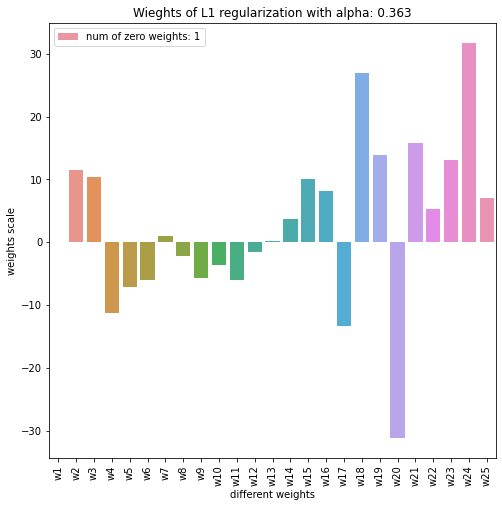

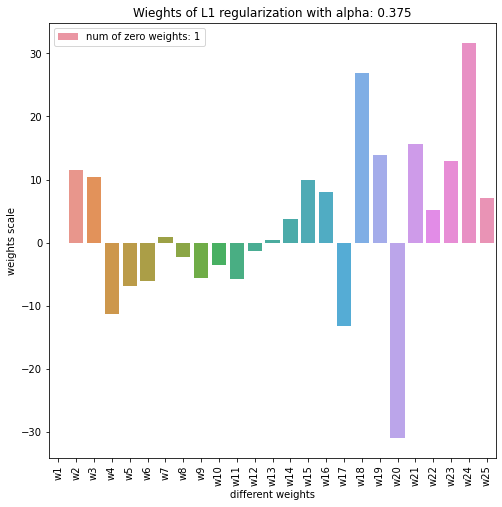

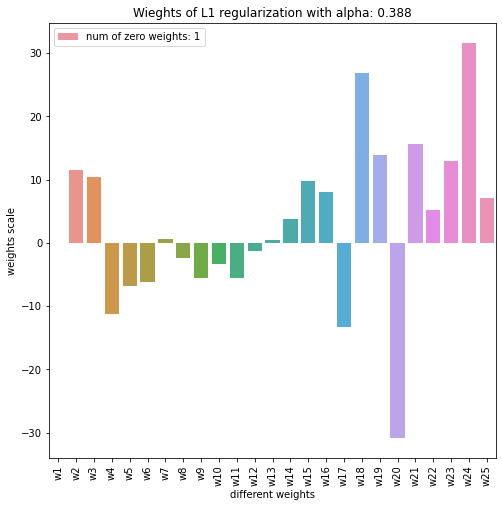

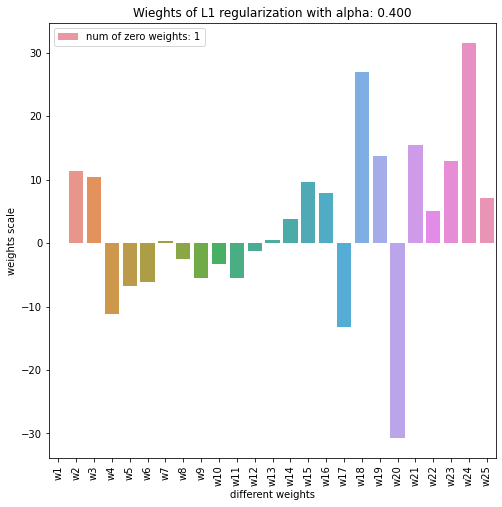

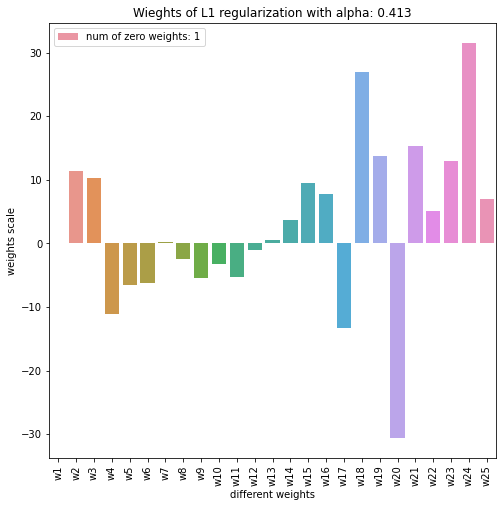

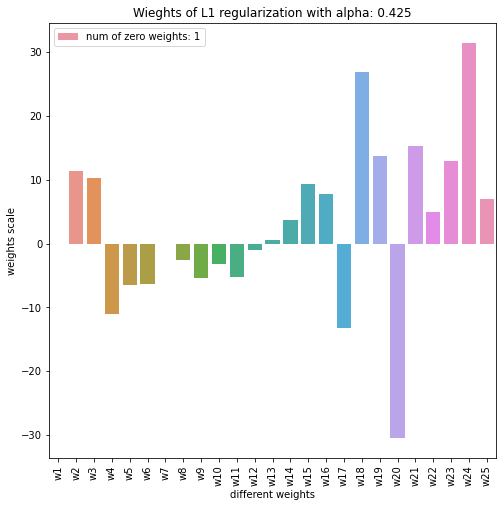

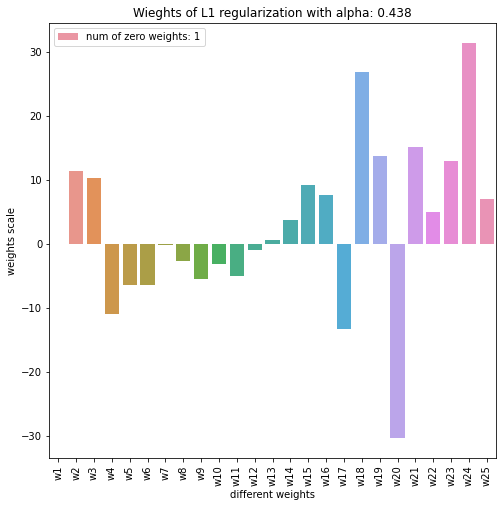

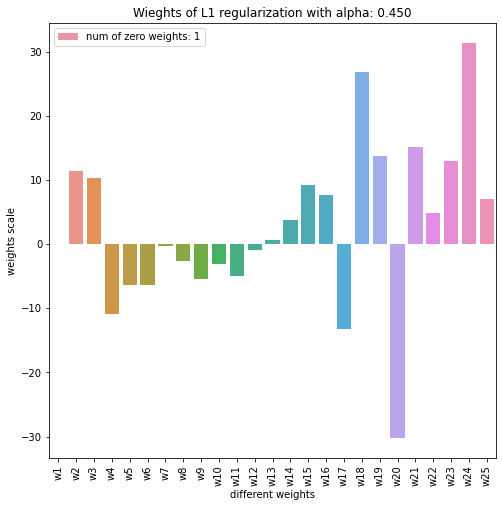

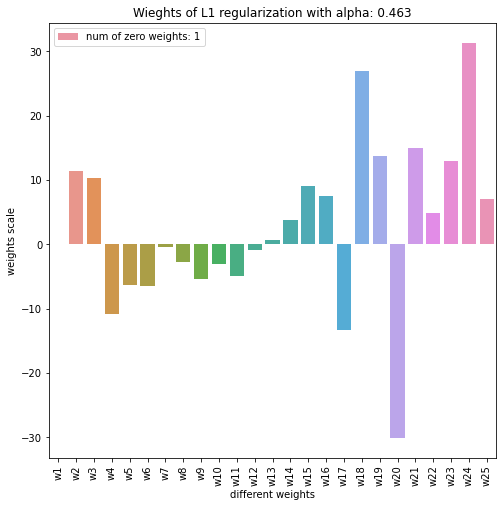

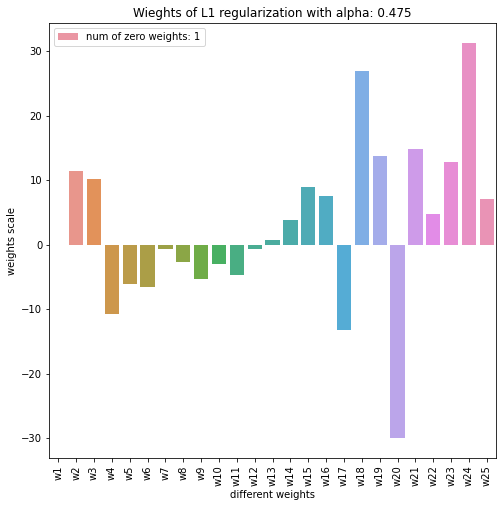

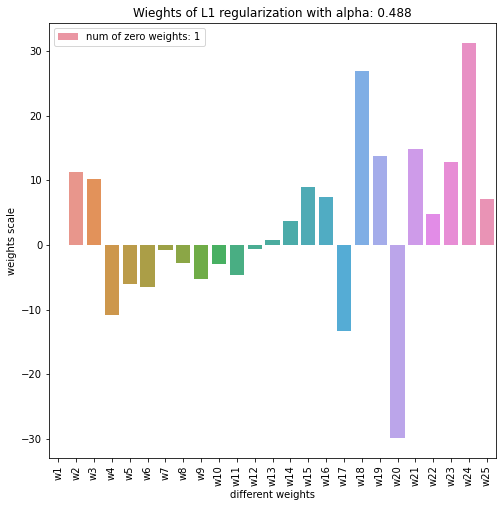

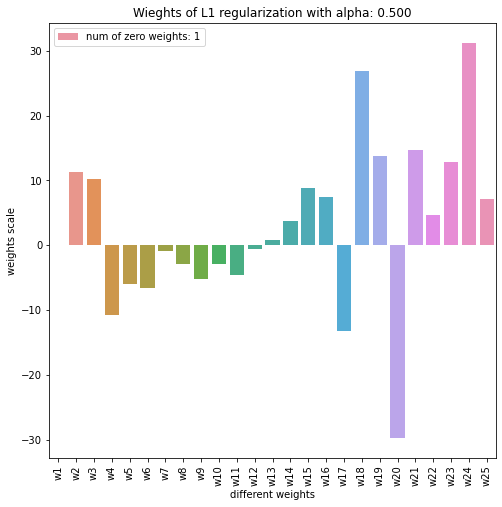

In [42]:
coefs_L2 = show_regularization(x_train, y_train, penalty='L2')

In [43]:
coefs_L2

,alpha_0.00,alpha_0.01,alpha_0.03,alpha_0.04,alpha_0.05,alpha_0.06,alpha_0.08,alpha_0.09,alpha_0.10,alpha_0.11,...,alpha_0.39,alpha_0.40,alpha_0.41,alpha_0.43,alpha_0.44,alpha_0.45,alpha_0.46,alpha_0.48,alpha_0.49,alpha_0.50
w1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
w2,23.153700,12.281130,12.436036,12.403511,12.338156,12.268257,12.201129,12.138727,12.081338,12.028698,...,11.445937,11.431178,11.416874,11.402994,11.389512,11.376400,11.363636,11.351198,11.339065,11.327220
w3,151.574677,21.650111,17.601901,15.599917,14.399666,13.600323,13.030459,12.604149,12.273526,12.009810,...,10.379985,10.355761,10.332712,10.310730,10.289720,10.269597,10.250284,10.231714,10.213827,10.196569
w4,-539.753840,-12.845419,-15.070679,-15.316846,-15.158802,-14.894092,-14.607128,-14.326259,-14.061288,-13.815045,...,-11.187650,-11.128896,-11.072563,-11.018488,-10.966522,-10.916528,-10.868382,-10.821970,-10.777186,-10.733933
w5,-1502.040875,-69.979692,-46.649393,-35.388809,-28.695164,-24.256413,-21.100466,-18.744400,-16.920614,-15.468751,...,-6.811991,-6.700814,-6.596532,-6.498527,-6.406256,-6.319231,-6.237020,-6.159234,-6.085527,-6.015583
w6,6563.474061,-20.596267,-8.643785,-5.332091,-4.110212,-3.640720,-3.497611,-3.510709,-3.602064,-3.732636,...,-6.148347,-6.208112,-6.265190,-6.319742,-6.371919,-6.421860,-6.469694,-6.515541,-6.559513,-6.601714
w7,6445.016109,113.992784,70.386762,50.393503,38.714498,31.026416,25.576294,21.510179,18.360525,15.849366,...,0.592217,0.389607,0.199403,0.020533,-0.147954,-0.306907,-0.457086,-0.599169,-0.733770,-0.861442
w8,-36508.568350,45.570917,22.313790,14.019745,9.747554,7.130476,5.355233,4.067392,3.087684,2.315588,...,-2.369488,-2.435259,-2.497285,-2.555884,-2.611338,-2.663899,-2.713791,-2.761217,-2.806359,-2.849382
w9,-13478.952897,-35.614198,-19.504453,-14.443645,-12.008642,-10.579804,-9.637747,-8.967047,-8.462854,-8.068189,...,-5.565933,-5.524378,-5.484716,-5.446795,-5.410482,-5.375657,-5.342213,-5.310052,-5.279086,-5.249238
w10,104091.276110,-25.139428,-17.063232,-13.780514,-11.832758,-10.488908,-9.483271,-8.691668,-8.046686,-7.507869,...,-3.421295,-3.351645,-3.285670,-3.223090,-3.163655,-3.107139,-3.053336,-3.002059,-2.953141,-2.906425


#### Summary

> as we saw bigger regularization -> smaller scale of weights
> also L1 as we saw at the top make some of them totally equal to zero
> while L2 shirnks them all to +- same scale with out zeroing.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [44]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X_hw, y_hw, test_size=.2)

In [46]:
# first train with out scaling
alphas = np.geomspace(10e-4, 10e4, 50)
params = {
        'alpha': alphas
    }

def train_model(x, y, penalty='L1', scale=False):
    alphas = np.geomspace(10e-4, 10e4, 50)
    params = {
        'alpha': alphas
    }
    if penalty == 'L1':
        model = Lasso()
    elif penalty == 'L2':
        model = Ridge()
    
    if scale == True:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        
    grid = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error',
                        return_train_score=True, cv=5, n_jobs=-1)

    grid.fit(x, y)
    
    rmse_train, rmse_val = -grid.cv_results_['mean_train_score'], -grid.cv_results_['mean_test_score'] 
    coefs = grid.best_estimator_.coef_
    best_params = grid.best_params_
    coefs_labels = [f'w{i}' for i in range(1, x_train.shape[1] + 1)]
    sns.barplot(x=coefs_labels, y=coefs, label=f'best params: {best_params}')
    plt.title('weights of best model')
    plt.xticks(rotation=90);
    plt.legend()

    plt.ylabel('weights scale');
    plt.xlabel('weight');
    return rmse_train, rmse_val, coefs

#### L1

> With out scaling

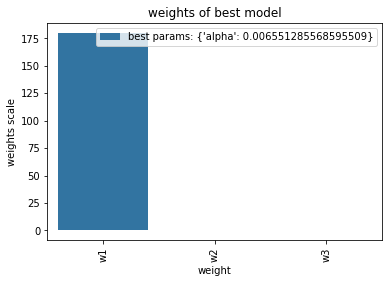

In [47]:
rmse_train_l1, rmse_val_l1, coefs_l1 = train_model(x_train, y_train, penalty='L1', scale=False)

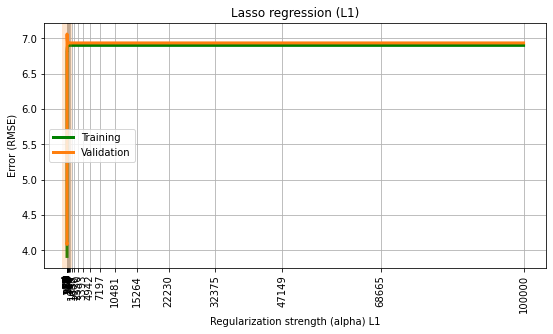

In [48]:
plot_fitting_graph(params['alpha'], rmse_train_l1, rmse_val_l1,
                   xlabel='Regularization strength (alpha) L1', ylabel='Error (RMSE)',
                   title='Lasso regression (L1)')

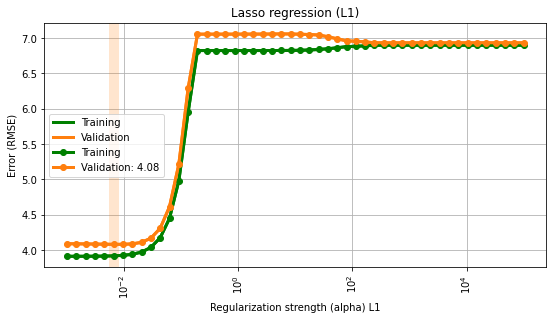

In [49]:
plot_fitting_graph(params['alpha'], rmse_train_l1, rmse_val_l1,
                   xlabel='Regularization strength (alpha) L1', ylabel='Error (RMSE)',
                   title='Lasso regression (L1)', x_axis_scale=True, show_points=True)

> With feature scaling

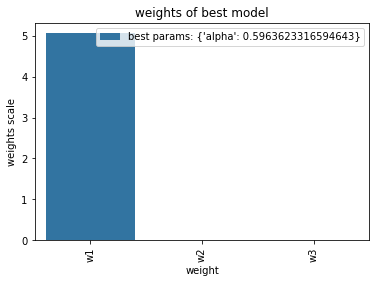

In [50]:
rmse_train_l1_sc, rmse_val_l1_sc, coefs_l1_sc = train_model(x_train, y_train, penalty='L1', scale=True)

> Wee see that scale of features became slower

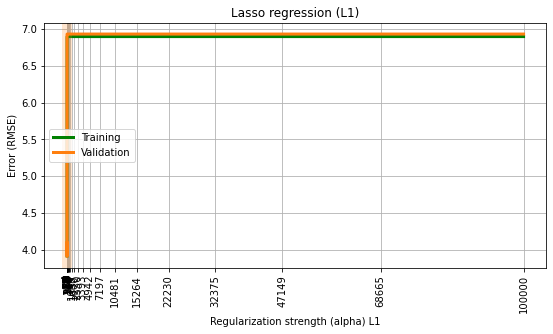

In [51]:
plot_fitting_graph(params['alpha'], rmse_train_l1_sc, rmse_val_l1_sc,
                   xlabel='Regularization strength (alpha) L1', ylabel='Error (RMSE)',
                   title='Lasso regression (L1)')

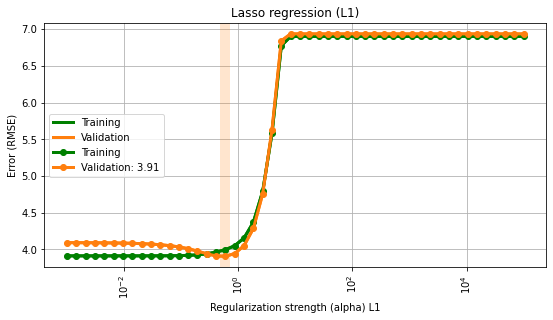

In [52]:
plot_fitting_graph(params['alpha'], rmse_train_l1_sc, rmse_val_l1_sc,
                   xlabel='Regularization strength (alpha) L1', ylabel='Error (RMSE)',
                   title='Lasso regression (L1)', x_axis_scale=True, show_points=True)

#### L2

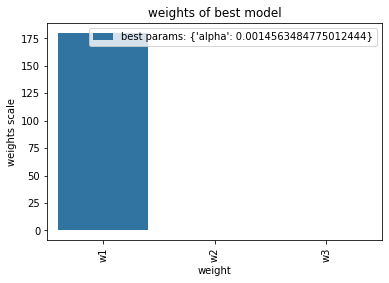

In [53]:
rmse_train_l2, rmse_val_l2, coefs_l2 = train_model(x_train, y_train, penalty='L2', scale=False)

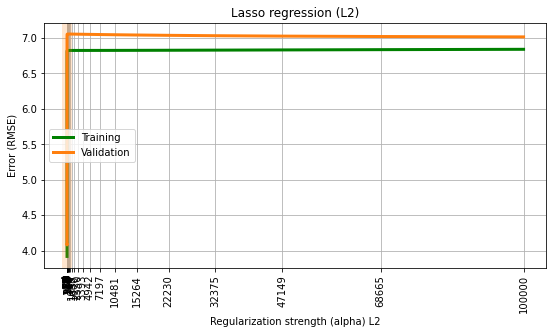

In [54]:
plot_fitting_graph(params['alpha'], rmse_train_l2, rmse_val_l2,
                   xlabel='Regularization strength (alpha) L2', ylabel='Error (RMSE)',
                   title='Lasso regression (L2)')

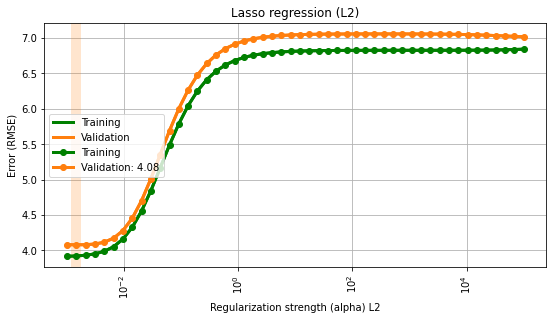

In [55]:
plot_fitting_graph(params['alpha'], rmse_train_l2, rmse_val_l2,
                   xlabel='Regularization strength (alpha) L2', ylabel='Error (RMSE)',
                   title='Lasso regression (L2)', x_axis_scale=True, show_points=True)

> With scaling

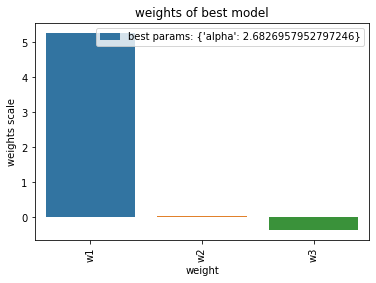

In [56]:
rmse_train_l2_sc, rmse_val_l2_sc, coefs_l2_sc = train_model(x_train, y_train, penalty='L2', scale=True)

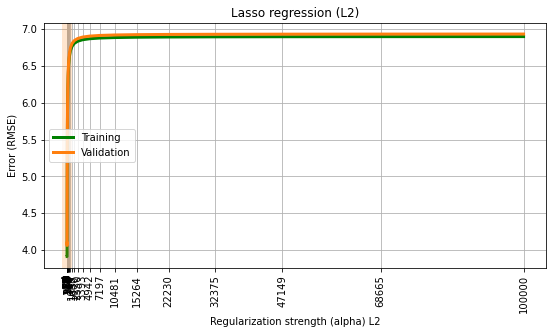

In [57]:
plot_fitting_graph(params['alpha'], rmse_train_l2_sc, rmse_val_l2_sc,
                   xlabel='Regularization strength (alpha) L2', ylabel='Error (RMSE)',
                   title='Lasso regression (L2)')

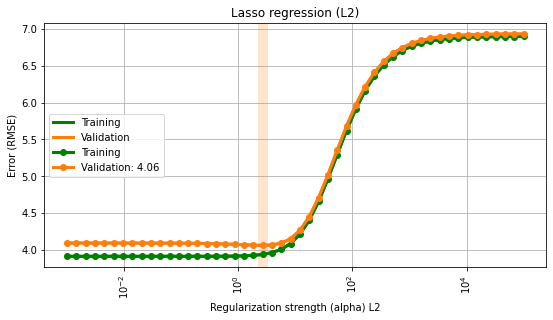

In [58]:
plot_fitting_graph(params['alpha'], rmse_train_l2_sc, rmse_val_l2_sc,
                   xlabel='Regularization strength (alpha) L2', ylabel='Error (RMSE)',
                   title='Lasso regression (L2)', x_axis_scale=True, show_points=True)

#### Summary



In [59]:
## your observations/conclusions

> As we can see when we use feature scaling out weights scale become lower and
> and it is also better for interpretebility our results
> and for generalization of our model.
> If we don't use feature feature scaling our features will have different impact on our model.
> For example if one features have range 1000 - 2000, others: 0.5 - 1 -> 
    much bigger impact will give first feature if it is even not better then second.
> Also if out features are really should make not
equal contribution to model we really can save it in different scales, 
but when fitting model just can learn bigger coefficents before them :)